## <p align="center">TFG: SIMULATION OF NUCLEAR SHELL MODELL WITH QUANTUM CIRCUITS</p>
#### <p align="center">CARLOS RAMON ESCANDELL</p>
#### <p align="center">ADVISOR: AXEL PÉREZ-OBIOL</p>
##### <p align="center">Spring semester 2023</p>

##### ABSTRACT:
This thesis focuses on the study of the nuclear shell-model through the implementation of quantum circuits. The nuclear shell-model can be described within a valence space, wherein each single-particle state is associated with a qubit $|1\rangle$ if occupied and $|0\rangle$ if empty. By employing the system's Hamiltonian and utilizing the Jordan-Wigner mapping, creation and annihilation fermion operators can be transformed into Pauli matrix terms, enabling their implementation in a quantum circuit. To simulate this system, an adaptive variational quantum eigensolver (ADAPT-VQE) is employed, which iteratively constructs a wavefunction that minimizes the energy at each step. Through repeated iterations, an upper bound for the ground state energy is obtained, as well as the associated wavefunction approximation.

# INDEX

1. [INTRODUCTION](#1-introduction)
2. [NUCLEAR SHELL-MODEL](#2-nuclear-shell-model)
3. [ADAPT-VQE](#3-adapt-vqe)
4. [CLASSICAL SIMULATION OF THE ADAPT-VQE ALGORITHM](#4-classical-simulation-of-the-adapt-vqe-algorithm)
    - 4.1 [OXYGEN-18](#41-oxygen-18)
    - 4.2 [BERYLLIUM-10](#42-berilyium-10)
    - 4.3 [LITHIUM-6](#43-lithium-6)
5. [ADAPT-VQE WITH QUANTUM CIRCUIT](#5-adapt-vqe-with-quantum-circuit)
    - 5.1 [MAPPING](#51-mapping)
    - 5.2 [INITIAL STATE PREPARATION](#52-initial-state-preparation)
    - 5.3 [EVOLUTION OF THE STATE: STAIRCASE ALGORITHM](#53-evolution-of-the-state-staircase-algorithm)
6. [SIMULATION](#6-simulation)
    - 6.1 [OXYGEN-18](#61-oxygen-18)
    - 6.2 [BERYLLIUM-10](#62-beryllium-10)
    - 6.3 [LITHIUM-6](#63-lithium-6)
7. [EXPECTATION VALUE](#7-expectation-value)
    - 7.1 [ONEBODY EXPECTATION VALUE](#71-onebody-expectation-value)
    - 7.2 [TWO-BODY TERMS $h_{ijij}$](#72-two-body-terms-hijij)
    - 7.3 [TWO-BODY TERMS $h_{ijik}$](#73-two-body-terms-hijik)



### 1. INTRODUCTION
This notebook serves as a commentary on the code developed for my bachelor's thesis, where we delve into the field of nuclear physics using the nuclear shell-model as the foundation. The particular focus of this thesis is the implementation of an adaptive variational quantum eigensolver (ADAPT-VQE), a powerful tool in the current noisy intermediate-scale quantum (NISQ) era, which is designed to find the ground state wave function and energy of three different nuclei: Oxygen-18, Beryllium-10, and Lithium-6.

In the first part of the code, we will simulate the variational algorithm classically. That is, calculations will be performed through matrix simulation using the [OpenFermion library](https://quantumai.google/openfermion). This first part will serve as a benchmark for comparison when we build the variational algorithm using quantum circuits, thus aiding in better understanding the adaptive variational algorithm.

In the second part of the code, the adaptive variational algorithm is simulated using quantum circuits. For this, we utilize the [Qibo library](https://qibo.readthedocs.io/en/stable/api-reference/qibo.html), which allows us to construct quantum circuits and simulate them. Specifically, in this part, we implement the staircase algorithm, which will evolve the initial state to the state $e^{iT^{pq}_{rs}}|\psi\rangle$, and the expected value will be calculated classically.

In the third part of the code, we perform a measurement of the Hamiltonian with a given reference state, demonstrating a complete implementation. This calculation is performed separately from the previous part because simulating the adaptive variational algorithm as a whole would be computationally expensive. Therefore, it is introduced separately, and its joint implementation with the previous part could be trivially performed.


### 2. NUCLEAR SHELL-MODEL

The nuclear shell model is a fundamental model in nuclear physics, providing an understanding of the arrangement of nucleons within the atomic nucleus. Nucleons (protons and neutrons) are proposed to be situated at discrete energy levels inside the nucleus. Notably, certain "magic numbers" of nucleons display unique properties.

The atomic nucleus is conceptualized in two parts according to the shell model. The first part is an inert core of nucleons which have reached a "magic number", while the second part is a "valence space" with the remaining nucleons. For this valence space, an effective Hamiltonian can be expressed as:

$$
H_{\text{eff}} = \sum_i \epsilon_i a^{\dagger}_i a_i +\frac{1}{4}\sum_{ijkl} \overline{v}_{ijkl}a^{\dagger}_i a^{\dagger}_ja_l a_k
$$

where $\epsilon_i$ is the single-particle energy of state $i$ and $\overline{v}_{ijkl}$ are the two-body antisymmetric phenomenological couplings.

Given that nucleons are fermions and nuclear force is rotationally invariant, a single-particle basis with quantum numbers $nl_j$ is used, which also includes the isospin quantum number $t = 1/2$ to distinguish protons and neutrons.

The nuclear states can be expanded in this basis as:
$$
|JM \; TT_z \rangle = \sum_{\alpha} c_{\alpha} |\alpha, M T_z \rangle
$$

A challenge arises with the number of Slater determinants, which grow according to:

$$
dim_{mb} = \binom{dim_{sp}}{N_{CI}} \times \binom{dim_{sp}}{Z_{CI}}
$$

The shell model provides a comprehensive approach to understand atomic nuclei. However, it faces challenges when dealing with heavier nuclei due to the many-body Hilbert space's dimension.

Enter quantum computing. By mapping single-particle states in the nuclear shell model to qubits in a quantum computer via the Jordan-Wigner transformation, we could potentially handle larger configuration spaces currently inaccessible with classical computers. This approach promises new advancements in nuclear physics, given Variational Quantum Eigensolver (VQE) algorithms can effectively diagonalize the problem and withstand errors.


### 3 - ADAPT-VQE
**Understanding the Functioning of the Adaptive Variational Quantum Eigensolver**

The core function of the ADAPT-VQE algorithm is to iteratively construct a wavefunction in the following form:
$$
|\Psi(\boldsymbol{\theta})\rangle = \prod_{k=1}^{n} e^{i\theta_k A_k} |\text{ref}\rangle
$$
In this equation, $\boldsymbol{\theta} = \{\theta_k, \;k=1, \dots,n\}$ refers to a collection of variational parameters. In each iteration, a new parameter is introduced. The operators $A_k$ are combinations of fermionic creation and annihilation operators. The reference state, $|\text{ref}\rangle$, is the initial state upon which we iterate.

The algorithm seeks to find the set of variational parameters $\boldsymbol{\theta}$ that minimize the energy, as defined by the following equation:
$$
E_{\text{ADAPT-VQE}} = \min_{\boldsymbol{\theta}} \frac{\left\langle\psi(\boldsymbol{\theta})|H_{\text{eff}}|\psi(\boldsymbol{\theta})\right\rangle}{\left\langle\psi(\boldsymbol{\theta})|\psi(\boldsymbol{\theta})\right\rangle}
$$
The ansatz is then evolved through a unitary transformation $|\Psi(\boldsymbol{\theta})\rangle \xrightarrow[]{} e^{i\theta_k A_k}|\Psi(\boldsymbol{\theta})\rangle$. The operator $A_k$ is chosen based on which operator generates the largest gradient:

$$
\left. \frac{\partial E^{(n)}}{\partial \theta_k} \right|_{\theta_k = 0} = i\left\langle\psi(\boldsymbol{\theta})|[H_{\text{eff}},A_k]|\psi(\boldsymbol{\theta})\right\rangle |_{\theta_k = 0}
$$

The ADAPT-VQE algorithm employs a pre-determined set of available operators $A_k$. In the context of the nuclear shell-model, these operators are required to preserve particle number, total angular momentum $J$, its z-projection $M$, parity $\Pi$, and the third component of isospin $T_z$. Thus, we are motivated to utilize the following two-body fermionic operators:
$$
T_{rs}^{pq} = i(a_p^{\dagger}a_q^{\dagger}a_r a_s-a_r^{\dagger} a_s^{\dagger}a_p a_q)
$$
Here, p,q,r, and s are single-particle states with their quantum numbers $n$, $l$, $j$, $m$, and $t_z$.

Another preliminary step involves determining the reference state $|\text{ref}\rangle$ from which the algorithm starts iterating. This state is chosen as the lowest-energy configuration of the Fock basis within the Hamiltonian. The intention behind this choice is to decrease the number of required iterations. This method works for all simulated nuclei, with the exception of Lithium-6.

The ADAPT-VQE follows this procedure:
1. Compute all non-zero operators $T_{rs}^{pq}$ in the basis of the valence space.
2. Identify the minimum-energy Fock state of the Hamiltonian as the starting point for VQE iteration.
3. Find the operator $T_{rs}^{pq}$ that yields the maximum gradient.
4. Utilize a classical optimizer to find the value of $\theta$ that minimizes the energy. Here, we used the BFGS optimizer.
5. Evolve the state from $|\Psi(\boldsymbol{\theta})\rangle$ to $e^{i\theta_k A_k}|\Psi(\boldsymbol{\theta})\rangle$.
6. Return to step 3 and iterate until the system reaches the Ground State.

### 4- CLASSICAL SIMULATION OF THE ADAPT-VQE ALGORITHM.
In this section, we will simulate the ADAPT-VQE algorithm using matrix calculations. For this, we use the previously mentioned OpenFermion library. This initial matrix calculation will serve us to compare the results when the calculation is later performed using circuits.

We are going to simulate 3 different nuclei.

**A) OXYGEN-18:**
Files Required:
- Hamiltonian: hamiltonian_matrix_2_0.dat
- Many Body States: many_body_states_2_0.dat

**B) BERILLIUM-10:**
Files Required:
- Hamiltonian: hamiltonian_matrix_p_2_4.dat
- Many Body States: many_body_states_p_2_4.dat

**C) LITHIUM-6:**
Files Required:
- Hamiltonian: hamiltonian_matrix_p_1_1.dat
- Many Body States: many_body_states_p_1_1.dat


In [54]:
# We start importing all the libraries that we need:
import numpy as np
from openfermion.ops import FermionOperator
from openfermion.linalg import get_sparse_operator
from openfermion.utils import hermitian_conjugated
from scipy.optimize import minimize
from scipy.sparse.linalg import expm_multiply
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
import time
import re

Now we are going to program a series of functions that will assist us in simulating the variational algorithm.

In [55]:
# We will use this function to transformthe fock to the computational basis:
def binary_to_decimal(lista,nqubits):
    """
    Function that takes a list of 1s and 0s as input and returns the decimal number associated with this set of 1s and 0s.
    """
    decimal  = 0
    for i in range(nqubits):
        decimal += lista[i] * (2**(len(lista)-i-1))
    return decimal

In [56]:
#This function recieves a list of vectors in the slater basis and returns a list of vectors in the computational basis:
def slatertocomputationalbasis(Vectors_slater, nqubits):
    """
    Input: list of vectors expressed in Slater basis
    Output: list of vectors expressed in the computational basis
    """
    computational_vectors = []  # List to store all vectors in the computational basis

    qbit_vectors = []  # Combinations of qubit terms, with a length of nqubits
    n1 = nqubits
    n2 = 2 ** int(nqubits)

    # Determine the vector in the qubit basis
    for element in Vectors_slater:
        qbit_basis_vect = [0 for i in range(n1)]
        for num in element:
            qbit_basis_vect[num] = 1

        qbit_vectors.append(qbit_basis_vect)  # Add to the qbit list

    # Convert binary numbers to their corresponding decimals
    list_fock_basis = []
    for element in qbit_vectors:
        number = binary_to_decimal(element, nqubits)
        list_fock_basis.append(number)

    # For each decimal number in the list_fock_basis, create a vector with all zeros and
    # a 1 at the position of the decimal number
    for decimal_num in list_fock_basis:
        comp_basis_vect = [0 for j in range(n2)]
        comp_basis_vect[decimal_num] = 1

        computational_vectors.append(comp_basis_vect)

    return computational_vectors


In [57]:
# This function recieves a list of vectors in the fock basis and returns a list of vectors in the computational basis:
def slatertofocklbasis(Vectors_slater, nqubits): 
    """
    Input: list of vectors expressed in Slater basis
    Output: list of vectors expressed in "Fock basis"
    """
    qbit_vectors = []  # Combinations of qubit terms, with a length of nqubits
    n1 = nqubits

    # First, let's determine the vector in the qubit basis:
    for element in Vectors_slater:
        qbit_basis_vect = [0 for i in range(n1)]
        for num in element:
            qbit_basis_vect[num] = 1

        qbit_vectors.append(qbit_basis_vect)  # Add them to a list of qubits

    # Now, we convert the binary numbers to their corresponding decimals. We will return this list of numbers.
    list_fock_basis = []
    for element in qbit_vectors:
        num = binary_to_decimal(element, nqubits)
        list_fock_basis.append(num)

    return list_fock_basis

In [58]:
#This function reads the hamiltonian
def transformH(file, Slater_basis, nqubits):
    """
    INPUT: file (str) -> file name
           Slater_basis (list) -> basis of the Hamiltonian
           nqubits (int) -> number of qubits

    OUTPUT: H (csr_matrix) in the computational basis
    """
    # Read the file and extract the data
    with open(file, 'r') as f:
        data = [line.strip().split() for line in f]

    rows, cols, values = zip(*((int(line[0]), int(line[1]), float(line[2])) for line in data))

    # Build the Hamiltonian matrix in the Slater basis
    dim = len(Slater_basis)
    hamiltonian_Slaterbasis = np.zeros((dim, dim))
    hamiltonian_Slaterbasis[rows, cols] = values

    # Transform the Hamiltonian matrix to the computational basis
    n = 2**nqubits
    hamiltonian_compbasis = np.zeros((n, n))

    vectors_fock = slatertofocklbasis(Slater_basis, nqubits)

    # Map the matrix elements to the corresponding indices in the computational basis
    for i, j, value in zip(rows, cols, values):
        index1, index2 = vectors_fock[i], vectors_fock[j]
        hamiltonian_compbasis[index1, index2] = value

    # Create a sparse matrix representation in the computational basis
    hamiltonian_sparse = csr_matrix(hamiltonian_compbasis)

    return hamiltonian_sparse


In [59]:
# With this function we find the state we are going to use as initial state:
def StateMinEnergy2(file, Slater_basis):
    """
    INPUT: file (str) -> file name
           Slater_basis (list) -> basis of the Slater vectors

    OUTPUT: min_vector (list) -> vector in the Slater basis with the minimum energy
            min_value (float) -> minimum energy value
    """
    with open(file, 'r') as f:
        # Read each line of the file and add it to a list
        data = [line.strip().split() for line in f]

    # Extract data into different lists
    rows = [int(line[0]) for line in data]
    values = [float(line[2]) for line in data]

    # Find the minimum energy value and its corresponding index
    min_value = min(values)
    index = values.index(min_value)

    # Retrieve the vector in the Slater basis with the minimum energy
    index_slater = rows[index]
    min_vector = Slater_basis[index_slater]

    return min_vector, min_value


As we explained before, the fermionic operators used in this work correspond to two-body operators of the form:
$$
T_{rs}^{pq} = i(a_p^{\dagger}a_q^{\dagger}a_r a_s-a_r^{\dagger} a_s^{\dagger}a_p a_q)
$$
What the following function does is take these operators and calculate a pool of $T_{rs}^{pq}$ that are non-zero in the many-body basis that is passed as an argument. The function will write a file with all the non-zero operators that exist in that particular basis. This calculation prior to the simulation of the variational algorithm will serve us later to select the $T_{rs}^{pq}$ operator that gives us the greatest gradient.

In [60]:
#This function computes all the nonzero fermion operatos in this basis:
def NonZeroOperators(BasisVectors,FileName):
    """
    Input (list): This function receives a list of all the vectors of the basis.
    Output (list) : List of all the Non Zero Fermionic operators.
    """
    start_time = time.time()
    non_zero_operators = []  # list where we will store all the non-zero fermionic operators
    
    # first we detect which is the largest and the smallest number in the basis:
    components = [x for tup in BasisVectors for x in tup]

    maxc = max(components)
    minc = min(components)

    # we now iterate creating all possible fermionic operators
    with open(FileName, "w") as f:
        for p in range(minc, maxc+1):
            for q in range(p, maxc+1):
                for r in range(minc, maxc+1):
                    for s in range(r, maxc+1):
                        for i in range(len(BasisVectors)):
                            for j in range(i, len(BasisVectors)):

                                vec1 = BasisVectors[i]
                                vec2 = BasisVectors[j]

                                if (p != q and (p in vec1) and (q in vec1) and (s != r) and (s in vec2) and (r in vec2)):  

                                    vec1_copy = vec1.copy()
                                    vec2_copy = vec2.copy()

                                    OF_Operator = FermionOperator(((p, 1), (q, 1), (r, 0), (s, 0)))
                                    # now we have to select only those operators which have the same terms in the bra as in the ket

                                    vec2_copy.remove(s)
                                    vec1_copy.remove(p)
                                    vec2_copy.remove(r)
                                    vec1_copy.remove(q)

                                    if (vec1_copy == vec2_copy) and (OF_Operator not in non_zero_operators):                                       

                                        non_zero_operators.append(OF_Operator)
                                        f.write(str(OF_Operator) + "\n")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Non-zero fermionic operators calculation: ",elapsed_time)
    print("**********************************************************************************************************")
    return(non_zero_operators)

Now we are going to code some functions that will help us to compute the Fermion Operator with the maximum gradient.

**How do we compute the gradient?**

We begin with the expression for the minimization of energy:

$$
E_{\text{ADAPT-VQE}} = \min_{\bold{\theta}} \frac{\left\langle\psi(\boldsymbol{\theta})|H_{\text{eff}}|\psi(\boldsymbol{\theta})\right\rangle}{\left\langle\psi(\boldsymbol{\theta})|\psi(\boldsymbol{\theta})\right\rangle}
$$

Since the wave function is already normalized, we can write the energy as $E = \left\langle\psi(\boldsymbol{\theta})|H_{\text{eff}}|\psi(\boldsymbol{\theta})\right\rangle$. At each step $k$ of the iterative procedure, the ansatz is expanded by: $|\psi(\bold{\theta}\rangle \xrightarrow[]{} e^{i\theta_k A_k}|\psi(\bold{\theta}\rangle$. Therefore, at each step, we need to compute: 

$$
E =\langle e^{i\theta_k A_k }\psi(\boldsymbol{\theta})|H_{\text{eff}}|e^{i\theta_k A_k}\psi(\boldsymbol{\theta})\rangle
$$

Differentiating this expression with respect to $\theta_k$ yields:

\begin{align*}
    & \frac{\partial E}{\partial \theta_k} = \frac{\partial}{\partial \theta_k}\left\langle e^{i\theta_k A_k}\psi(\boldsymbol{\theta})|H_{\text{eff}}|e^{i\theta_k A_k}\psi(\boldsymbol{\theta})\right\rangle \\
    & = \left\langle \psi(\boldsymbol{\theta})\left|\frac{\partial}{\partial \theta_k}[e^{-i\theta_k A_k}\hspace{0.1cm}H_{\text{eff}} \hspace{0.1cm} e^{i\theta_k A_k}]\right|\psi(\boldsymbol{\theta})\right\rangle \\
    & = \langle \psi(\boldsymbol{\theta})\left|e^{-i\theta_k A_k}\left(-iA_k\right)\hspace{0.1cm}H_{\text{eff}} \hspace{0.1cm} e^{i\theta_k A_k} + e^{-i\theta_k A_k}\hspace{0.1cm}H_{\text{eff}} \hspace{0.1cm}(iA_k)e^{i\theta_k A_k}\right|\psi(\boldsymbol{\theta})\rangle \\
    & = i\left\langle \psi(\boldsymbol{\theta})\left|e^{-i\theta_k A_k}\left[-A_k\hspace{0.1cm}H_{\text{eff}} \hspace{0.1cm} +\hspace{0.1cm}H_{\text{eff}} \hspace{0.1cm}A_k\right]e^{i\theta_k A_k}\right|\psi(\boldsymbol{\theta})\right\rangle \\
    & = i\left\langle e^{i\theta_k A_k}\psi(\boldsymbol{\theta})|[H_{\text{eff}},A_k]|e^{i\theta_k A_k}\psi(\boldsymbol{\theta})\right\rangle
\end{align*}

To derive the final result, we evaluate this expression at $\theta_k = 0$ to obtain:

$$
    \left. \frac{\partial E}{\partial \theta_k} \right|_{\theta_k = 0} = i\left\langle\psi(\boldsymbol{\theta})|[H_{\text{eff}},A_k]|\psi(\boldsymbol{\theta})\right\rangle |_{\theta_k = 0}
$$

In the case we are dealing with, where the matrices $H_{eff}$ and $A_k$ are very large, it is useful to simplify the commutator and reduce it to a single matrix product. To achieve this, we use that both $H_{eff}$ and $A_k$ are Hermitian and attempt to simplify the problem:

\begin{align*}
    i\left\langle\psi(\boldsymbol{\theta})|[H_{\text{eff}},A_k]|\psi(\boldsymbol{\theta})\right\rangle &= i\left[\left\langle\psi(\boldsymbol{\theta})|H_{\text{eff}}A_k|\psi(\boldsymbol{\theta})\right\rangle -\left\langle\psi(\boldsymbol{\theta})|A_kH_{\text{eff}}|\psi(\boldsymbol{\theta})\right\rangle \right] \\
    &= i\left[\left\langle |H_{\text{eff}}^{\dagger}\psi(\boldsymbol{\theta})|A_k\psi(\boldsymbol{\theta})\right\rangle -\left\langle A_k^{\dagger}\psi(\boldsymbol{\theta})|H_{\text{eff}}\psi(\boldsymbol{\theta})\right\rangle \right] \\
    &= i\left[\left\langle |H_{\text{eff}}\psi(\boldsymbol{\theta})|A_k\psi(\boldsymbol{\theta})\right\rangle -\left\langle A_k\psi(\boldsymbol{\theta})|H_{\text{eff}}\psi(\boldsymbol{\theta})\right\rangle \right] \\
    &= i\left[\left\langle |H_{\text{eff}}\psi(\boldsymbol{\theta})|A_k\psi(\boldsymbol{\theta})\right\rangle -\left(\left\langle H_{\text{eff}}\psi(\boldsymbol{\theta})|A_k\psi(\boldsymbol{\theta})\right\rangle\right)^{*} \right]
\end{align*}

If we define $ z = \left\langle |H_{\text{eff}}\psi(\boldsymbol{\theta})|A_k\psi(\boldsymbol{\theta})\right\rangle$ :

$$
i\left[z-z^*\right] = i\left[ (a+ib) - (a-ib) \right] = i[2ib] = -2b = -2 \cdot \text{Im}(z)
$$

Thus, we have shown that we can write:

$$
    i\left\langle\psi(\boldsymbol{\theta})|[H_{\text{eff}},A_k]|\psi(\boldsymbol{\theta})\right\rangle = -2\cdot Im\left[ \left\langle\psi(\boldsymbol{\theta})|H_{\text{eff}}A_k|\psi(\boldsymbol{\theta})\right\rangle \right]

$$


In [61]:
def swap_elements(input_file_path, output_file_path):
    with open(input_file_path, 'r') as input_file, open(output_file_path, 'w') as output_file:
        # Regular expression to parse input lines
        line_regex = re.compile(r'(\d+\.\d+) \[(\d+)\^ (\d+)\^ (\d+) (\d+)\]')

        # Iterate through all the lines in the input file
        for line in input_file:
            # Match the input line with the regex
            match = line_regex.match(line.strip())

            if match:
                # Extract matched elements
                value, first_num, second_num, third_num, fourth_num = match.groups()

                # Reconstruct the output line by swapping the first two numbers and using the third and fourth numbers from the same line
                output_line = f"{value} [{third_num}^ {fourth_num}^ {first_num} {second_num}]"

                # Write the output line to the output file
                output_file.write(output_line + '\n')

In [62]:
def FermionOperatorMaxGradient(FileFermions,FileFermionsSwap,vector,sparse_H,nqubits):
    """
    This function computes the maximum gradient for a given vector.
    INPUT:
    FileFermions: File with the non zero fermion operators.
    vector: The vector in which we want to compute the maximum gradient.
    sparse_H: The sparse Hamiltonian matrix.
    nqubits: Number of qubits.
    OUTPUT:
    max_T: list with all the operators T that gives the maximun gradient.
    """

    values = []
    operadors_utilitzats = []
    
    # We compute the bra outside the loop since it is the same always, it does not depend on the fermionic operator.
    bra = np.conj(sparse_H.dot(vector)).transpose()

    with open(FileFermions, "r") as FermionOperators1, open(FileFermionsSwap, "r") as FermionOperators2:
        lines1 = FermionOperators1.readlines()
        lines2 = FermionOperators2.readlines()
        for (line1,line2) in zip(lines1,lines2):

            FO = FermionOperator(line1)
            FO_conj = FermionOperator(line2)

            T = 1.0j * (FO - FO_conj) # T = 1.0j * (FO - FO.conjugate())

            # Extract the specified row from the sparse operator as a sparse vector
            ket = get_sparse_operator(T, nqubits).dot(vector)
            valor = abs(2.0*(bra.dot(ket)[0,0]).imag)
            
            if valor != 0.0:
                values.append(valor)
                operadors_utilitzats.append(T)
            

    Maxvalor = max(values)
    max_T = [operadors_utilitzats[i] for i in range(len(values)) if values[i] == Maxvalor]
    print(max_T)

    return max_T

In [63]:
#Now we have to make a function that computes the energy depending on a parameter theta and recieves a list of all the theta's
# and all the sparse_T's:
def expected_value(thetas, list_T_sparse, H_sparse, vector):
    """
    This function computes the expected value of the hamiltonian depending on a list of thetas.
    INPUT:
    thetas: List of parameters theta.
    list_T_sparse: List with all the sparse_T's.
    H_sparse: The sparse Hamiltonian matrix.
    vector: The vector in which we want to compute the expected value.
    OUTPUT:
    energy: The expected value of the energy.
    """
    psi = vector.copy()
    for i in range(len(thetas)):
        psi = expm_multiply(1.0j * thetas[i] * list_T_sparse[i], (psi))

    psic = np.conj(H_sparse.dot(psi)).transpose()
    result = (psic.dot(psi)[0, 0]).real
    return result

In [64]:
def FermionOperatorMaxGradientevol(FileFermions,FileFermionsSwap,vector,sparse_H,nqubits,list_T_sparse,list_theta):
    """
    This function computes the maximum gradient for a given vector.
    INPUT:
    FileFermions: File with the non zero fermion operators.
    vector: The vector in which we want to compute the maximum gradient.
    sparse_H: The sparse Hamiltonian matrix.
    nqubits: Number of qubits.
    OUTPUT:
    max_T: list with all the operators T that gives the maximun gradient.
    """

    values = []
    operadors_utilitzats = []
    
    psi = vector.copy()
    for i in range(len(list_theta)):
        psi = expm_multiply(1.0j*list_theta[i]*list_T_sparse[i],(psi.copy())) #HA DE SER UN +1.0j

    # We compute the bra outside the loop since it is the same always, it does not depend on the fermionic operator.
    bra = np.conj(sparse_H.dot(psi)).transpose()

    with open(FileFermions, "r") as FermionOperators1, open(FileFermionsSwap, "r") as FermionOperators2:
        lines1 = FermionOperators1.readlines()
        lines2 = FermionOperators2.readlines()

        for (line1,line2) in zip(lines1,lines2):

            FO = FermionOperator(line1)
            FO_conj = FermionOperator(line2)

            T = 1.0j * (FO - FO_conj) # T = 1.0j * (FO - FO.conjugate())

            ket = get_sparse_operator(T, nqubits).dot(psi)
            valor = abs(2.0*(bra.dot(ket)[0,0]).imag)

            
            if valor != 0.0:
                values.append(valor)
                operadors_utilitzats.append(T)
                #print("Gradient value:", valor)
            

    Maxvalor = max(values)
    max_T = [operadors_utilitzats[i] for i in range(len(values)) if values[i] == Maxvalor]
    print(max_T)
    return max_T

In [65]:
def compute_expected_value(theta):
    return expected_value(theta,list_theta,list_T_sparse,H_sparse,min_energ_vector)

#### 4.1 OXYGEN-18: 
We start simulating the Oxygen-18 nucleus. 

Oxygen-18 is composed of 10 neutrons ($N=10$) and 8 protons ($Z=8$). This configuration results in having only 2 neutrons in the valence shell, specifically in the sd-shell, requiring the use of 12 qubits for its simulation.

In [66]:
# We start simulating the Oxygen-18.
#-----------------------------------------------------
nqubits = 12
FileHamiltonian = "hamiltonian_matrix_2_0.dat"
FileVectors = "many_body_states_2_0.dat"
epsilon = 0.001
theta_inicial = 0.0

NucleiName = "Oxygen-18"

In [67]:
#Now we compute the becnhmark energy:
def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy
#----------------------------------------------------------
GS_benchmark = GS_benchmark(FileHamiltonian)
print("GS ENERGY:",GS_benchmark)

GS ENERGY: -11.931788251561521


In [68]:
# We import and read now the basis that we are going to use:
with open(FileVectors, 'r') as f:
    lineas = f.readlines()[1:] # We skip the first line
    vectors = [[int(i) for i in linea.split('(')[1].split(')')[0].split(', ')] for linea in lineas]

In [69]:
# Here we have the sparse_hamiltonian of the system:
H_sparse = transformH(FileHamiltonian, vectors, nqubits)

In [70]:
NonZeroOperators(vectors,'NonZeroFermionicOperators-O-18.out')

input_file_path = 'NonZeroFermionicOperators-O-18.out'
FileFermionsSwap = 'SwapOperadoresfermionicosnonulos-O-18.out'
swap_elements(input_file_path, FileFermionsSwap)

Non-zero fermionic operators calculation:  0.2695894241333008
**********************************************************************************************************


Now we start with the first iteration of the VQE algorithm.

In [71]:
# First we compute the vector with the minimum energy:
energy_list = [] # For then plot the energy as a function of the iterations

#We first compute the minimum energy vector
min_energ_vector, ADAPT_VQE_energy = StateMinEnergy2(FileHamiltonian, vectors)
print("Minimum energy state:",min_energ_vector)
energy_list.append(ADAPT_VQE_energy)

qbit_basis_vect = [0 if i not in min_energ_vector else 1 for i in range(nqubits)]
number = binary_to_decimal(qbit_basis_vect, nqubits)

length = 2**nqubits
min_energ_vector = csr_matrix(([1], ([number], [0])), shape=(length, 1))

Minimum energy state: [0, 5]


In [72]:
#Now we build a list with all the theta's and all the sparse_T
list_T_sparse = []
list_theta = []

# We compute the first iteration of the algorithm:
T_expr1 = FermionOperatorMaxGradient('NonZeroFermionicOperators-O-18.out',FileFermionsSwap,min_energ_vector,H_sparse,nqubits)[0]
T1 = get_sparse_operator(T_expr1,nqubits)
list_T_sparse.append(T1)
with open(NucleiName + '_Fermionic_operators.out', 'a') as f:
        f.write(str(T_expr1) + '\n')


print("FIRST_ENERGY:",ADAPT_VQE_energy)
print("--------------------------------------------------------------------")
#----------------------------------------------------------

res = minimize(lambda thetas: expected_value(thetas, list_T_sparse, H_sparse, min_energ_vector),
               [theta_inicial], method='BFGS')#, tol = 10**(-10))

theta1 = res.x[0]
list_theta.append(theta1)
print("Theta0=",theta1)

energy = res.fun
energy_list.append(energy)
print("First energy iteration:",energy)

[1j [0^ 5^ 8 11] +
(-0-1j) [8^ 11^ 0 5]]
FIRST_ENERGY: -9.3151
--------------------------------------------------------------------
Theta0= -0.14940845059133684
First energy iteration: -9.605841136469657


In [73]:
# Now we compute the rest of the iterations of the algorithm:
#----------------------------------------------------------
iteracio = 1
while (abs(GS_benchmark)-abs(energy)) > epsilon:
    # Now we compute the next iteration of the algorithm:
    print("----------------------------------------------------------")
    print("iteration:", iteracio)
    T_expr = FermionOperatorMaxGradientevol('NonZeroFermionicOperators-O-18.out',FileFermionsSwap,min_energ_vector,H_sparse,nqubits,list_T_sparse,list_theta)[0]
    T = get_sparse_operator(T_expr,nqubits)
    list_T_sparse.append(T)


    with open(NucleiName + '_Fermionic_operators.out', 'a') as f:
        f.write(str(T_expr) + '\n')

    res = minimize(lambda thetas: expected_value(thetas, list_T_sparse, H_sparse, min_energ_vector),
                   list_theta + [theta_inicial], method='BFGS')

    list_theta = list(res.x)
    print("parameters_list",list_theta)

    energy = res.fun
    energy_list.append(energy)
    print("Energy:",energy)
    
    iteracio = iteracio + 1

----------------------------------------------------------
iteration: 1
[1j [0^ 5^ 6 7] +
(-0-1j) [6^ 7^ 0 5]]
parameters_list [-0.15227801855009035, -0.4730084961664532]
Energy: -10.109052363811312
----------------------------------------------------------
iteration: 2
[1j [0^ 5^ 1 4] +
(-0-1j) [1^ 4^ 0 5]]
parameters_list [-0.16238300220599933, -0.4686816251693708, 0.6516514190939926]
Energy: -10.86097970418054
----------------------------------------------------------
iteration: 3
[1j [0^ 5^ 9 10] +
(-0-1j) [9^ 10^ 0 5]]
parameters_list [-0.165634264484998, -0.4672942837869499, 0.6810380895432346, 0.16966043116011947]
Energy: -11.051118826396252
----------------------------------------------------------
iteration: 4
[1j [0^ 5^ 2 3] +
(-0-1j) [2^ 3^ 0 5]]
parameters_list [-0.15726667139694853, -0.43716650694724457, 0.6046048775168101, 0.214391686573455, -0.7853982894598058]
Energy: -11.931788251561436


In this case, the wave function that replicates the ground state of Oxygen-18 is:

$$
|\psi_{^{18} \text{O}} \rangle = e^{i\theta_4 T_{2,3}^{0,5}}e^{i\theta_3 T_{9,10}^{0,5}}e^{i\theta_2 T_{1,4}^{0,5}}e^{i\theta_1 T_{6,7}^{0,5}}e^{i\theta_0 T_{8,11}^{0,5}}X_0X_5|0\rangle^{\otimes 12}
$$

The associated values are as follows: $\theta_0$ = -0.15726, $\theta_1=$ -0.43724, $\theta_2$=0.60466, $\theta_3 =$ 0.21443, $\theta_4 =$ -0.78547.

Now we save the data to plot the convergence of the algorithm:

In [74]:
# SAVE DATA
#----------------------------------------------------------------------------------------------------
# iteration_list:
iteration_list = []
for i in range(len(energy_list)):
    iteration_list.append(i)


with open(NucleiName + '_ADAPT_VQE_energy.out', 'w') as f:
    for i, energy in zip(iteration_list, energy_list):
        rel_error = abs((energy - GS_benchmark) / GS_benchmark)
        f.write(str(i) + ' ' + str(energy) + ' ' + str(rel_error) + '\n')
#----------------------------------------------------------------------------------------------------
# Now we save all the theta values on a file:
print(list_theta)
with open(NucleiName + '_theta_values.out', 'w') as f:
    for theta in list_theta:
        f.write(str(theta) + '\n')

[-0.15726667139694853, -0.43716650694724457, 0.6046048775168101, 0.214391686573455, -0.7853982894598058]


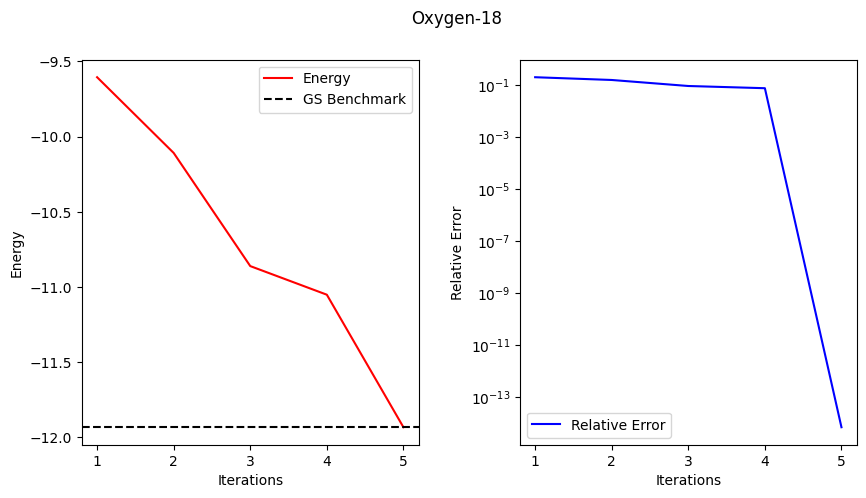

In [75]:
import matplotlib.pyplot as plt
import numpy as np
# Load data from file
data = np.loadtxt(NucleiName + '_ADAPT_VQE_energy.out')

# Extract columns from data
iterations = data[1:,0]
energy = data[1:,1]
rel_error = np.abs(data[1:,2])  # Take the absolute value of the relative error

# Create multiplot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot energy vs. iterations with benchmark on left subplot
ax1.plot(iterations, energy, 'r-', label="Energy")
ax1.axhline(y=GS_benchmark, color='k', linestyle='--', label="GS Benchmark")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Energy")
ax1.legend()
ax1.autoscale_view()  # Adjust axis to the data automatically

# Plot relative error vs. iterations on right subplot
ax2.plot(iterations, rel_error, 'b-', label="Relative Error")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Relative Error")

ax2.set_yscale("log")  # Set the y-axis to log scale
ax2.legend()

# Disable grid and minor ticks
ax2.grid(False)
ax2.minorticks_off()

ax2.autoscale_view()  # Adjust axis to the data automatically

# Add global title
fig.suptitle(NucleiName)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Save plot as PNG
plt.savefig(NucleiName + "_multiplot.png")

# Show the plot
plt.show()

#### 4.2 BERILYIUM-10:  
Beryllium-10 is composed of 6 neutrons ($N=6$) and 4 protons ($Z=4$). Consequently, we have 4 neutrons and 2 protons in the valence shell, necessitating the use of 12 qubits for the simulation within the p-shell

In [76]:
nqubits = 12
FileHamiltonian = "hamiltonian_matrix_p_2_4.dat"
FileVectors = "many_body_states_p_2_4.dat"
epsilon = 0.001
theta_inicial = 0.0

NucleiName = "Beryllium-10"

In [77]:
#Now we compute the becnhmark energy:
def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy
#----------------------------------------------------------
GS_benchmark = GS_benchmark(FileHamiltonian)
print("GS ENERGY:",GS_benchmark)

GS ENERGY: -39.453415798057065


In [78]:
# We import and read now the basis that we are going to use:
with open(FileVectors, 'r') as f:
    lineas = f.readlines()[1:] # We skip the first line
    vectors = [[int(i) for i in linea.split('(')[1].split(')')[0].split(', ')] for linea in lineas]

In [79]:
# Here we have the sparse_hamiltonian of the system:
H_sparse = transformH(FileHamiltonian, vectors, nqubits)

In [80]:
NonZeroOperators(vectors,'NonZeroFermionicOperators-Be-10.out')

input_file_path = 'NonZeroFermionicOperators-Be-10.out'
FileFermionsSwap = 'SwapOperadoresfermionicosnonulos-Be-10.out'
swap_elements(input_file_path, FileFermionsSwap)

Non-zero fermionic operators calculation:  8.929842472076416
**********************************************************************************************************


Now we start with the first iteration of the VQE algorithm.

In [81]:
# First we compute the vector with the minimum energy:
energy_list = [] # For then plot the energy as a function of the iterations

#We first compute the minimum energy vector
min_energ_vector, ADAPT_VQE_energy = StateMinEnergy2(FileHamiltonian, vectors)
print("Minimum energy state:",min_energ_vector)
energy_list.append(ADAPT_VQE_energy)

qbit_basis_vect = [0 if i not in min_energ_vector else 1 for i in range(nqubits)]
number = binary_to_decimal(qbit_basis_vect, nqubits)

length = 2**nqubits
min_energ_vector = csr_matrix(([1], ([number], [0])), shape=(length, 1))

Minimum energy state: [1, 2, 6, 7, 8, 9]


In [82]:
#Now we build a list with all the theta's and all the sparse_T
list_T_sparse = []
list_theta = []

# We compute the first iteration of the algorithm:
T_expr1 = FermionOperatorMaxGradient('NonZeroFermionicOperators-Be-10.out',FileFermionsSwap,min_energ_vector,H_sparse,nqubits)[0]
T1 = get_sparse_operator(T_expr1,nqubits)
list_T_sparse.append(T1)
with open(NucleiName + '_Fermionic_operators.out', 'a') as f:
        f.write(str(T_expr1) + '\n')


print("FIRST_ENERGY:",ADAPT_VQE_energy)
print("--------------------------------------------------------------------")
#----------------------------------------------------------

res = minimize(lambda thetas: expected_value(thetas, list_T_sparse, H_sparse, min_energ_vector),
               [theta_inicial], method='BFGS')#, tol = 10**(-10))

theta1 = res.x[0]
list_theta.append(theta1)
print("Theta0=",theta1)

energy = res.fun
energy_list.append(energy)
print("First energy iteration:",energy)

[(-0-1j) [1^ 2^ 4 5] +
1j [4^ 5^ 1 2], (-0-1j) [6^ 9^ 10 11] +
1j [10^ 11^ 6 9], (-0-1j) [7^ 8^ 10 11] +
1j [10^ 11^ 7 8]]
FIRST_ENERGY: -28.96475
--------------------------------------------------------------------
Theta0= -0.27172406620989986
First energy iteration: -30.01341800115237


Note: Beryllium-10 takes N=46 iterations to converge, so computationally it takes a significant amount of time to complete the simulation as it has to optimize all the parameters in each iteration.

In [83]:
# Now we compute the rest of the iterations of the algorithm.
#----------------------------------------------------------
iteracio = 1
while (abs(GS_benchmark)-abs(energy)) > epsilon:
    # Now we compute the next iteration of the algorithm:
    print("----------------------------------------------------------")
    print("iteration:", iteracio)
    T_expr = FermionOperatorMaxGradientevol('NonZeroFermionicOperators-Be-10.out',FileFermionsSwap,min_energ_vector,H_sparse,nqubits,list_T_sparse,list_theta)[0]
    T = get_sparse_operator(T_expr,nqubits)
    list_T_sparse.append(T)


    with open(NucleiName + '_Fermionic_operators.out', 'a') as f:
        f.write(str(T_expr) + '\n')

    res = minimize(lambda thetas: expected_value(thetas, list_T_sparse, H_sparse, min_energ_vector),
                   list_theta + [theta_inicial], method='BFGS')

    list_theta = list(res.x)
    print("parameters_list",list_theta)

    energy = res.fun
    energy_list.append(energy)
    print("Energy:",energy)
    
    iteracio = iteracio + 1

----------------------------------------------------------
iteration: 1
[(-0-1j) [6^ 9^ 10 11] +
1j [10^ 11^ 6 9], (-0-1j) [7^ 8^ 10 11] +
1j [10^ 11^ 7 8]]
parameters_list [-0.28283983185974115, 0.4620800493667245]
Energy: -31.886179310364536
----------------------------------------------------------
iteration: 2
[(-0-1j) [7^ 8^ 10 11] +
1j [10^ 11^ 7 8]]
parameters_list [-0.29356508284514415, 0.42665962001872443, -0.293417417561502]
Energy: -32.931061973809584
----------------------------------------------------------
iteration: 3
[(-0-1j) [2^ 7^ 4 11] +
1j [4^ 11^ 2 7], (-0-1j) [1^ 8^ 5 10] +
1j [5^ 10^ 1 8]]
parameters_list [-0.2962831844199107, 0.39819218636892445, -0.29688988238434616, 0.21116312018360575]
Energy: -33.45042006868978
----------------------------------------------------------
iteration: 4
[(-0-1j) [1^ 8^ 5 10] +
1j [5^ 10^ 1 8]]
parameters_list [-0.323500933997342, 0.35705468701137977, -0.32410334097053517, 0.27929665810086557, 0.2792966258348686]
Energy: -34.29085

In [84]:
# SAVE DATA
#----------------------------------------------------------------------------------------------------
# iteration_list:
iteration_list = []
for i in range(len(energy_list)):
    iteration_list.append(i)


with open(NucleiName + '_ADAPT_VQE_energy.out', 'w') as f:
    for i, energy in zip(iteration_list, energy_list):
        rel_error = abs((energy - GS_benchmark) / GS_benchmark)
        f.write(str(i) + ' ' + str(energy) + ' ' + str(rel_error) + '\n')
#----------------------------------------------------------------------------------------------------
# Now we save all the theta values on a file:
print(list_theta)
with open(NucleiName + '_theta_values.out', 'w') as f:
    for theta in list_theta:
        f.write(str(theta) + '\n')

[-0.12482995926814461, 0.29848243283821696, -0.31342903693985064, 0.10247194447881064, 0.10182630588979935, 0.6955869273393781, -0.31769412975913763, -0.2840740745456427, 0.4820487216897137, 0.17297632417840544, -0.1564254963554553, -0.1893659512461169, 0.233896425768537, -0.2562642592916075, -0.24634622355746003, -0.1441434451969254, -0.2250796528954133, -0.25267005549675375, 0.13773932400306688, 0.06378656229243304, -0.7004205832173361, 0.1571153996897084, 0.5540145447899805, 0.17957182379918463, -0.05517948359745493, 0.28574841046598026, 0.4155152828234456, 0.19393794825287916, 0.34796010553929607, -0.11931837838809342, 0.2630149730318283, -0.009770764219443897, -0.1736784199829176, -0.27302557766812846, -0.3148804461041491, 0.03352586077183695, 0.14222369136628077, -0.09336704231948571, -0.03694843956039661, 0.09463624163875621, 0.08348745915677999, 0.07325645029973299, -0.08660609439858437, 0.08948801249126288, -0.07595954323976441, -0.05647656587063182, -0.07532202195114378]


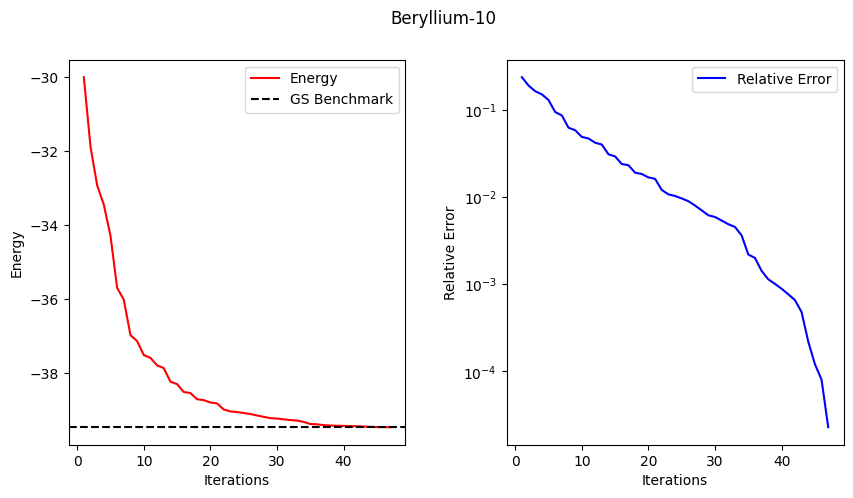

In [85]:
import matplotlib.pyplot as plt
import numpy as np
# Load data from file
data = np.loadtxt(NucleiName + '_ADAPT_VQE_energy.out')

# Extract columns from data
iterations = data[1:,0]
energy = data[1:,1]
rel_error = np.abs(data[1:,2])  # Take the absolute value of the relative error

# Create multiplot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot energy vs. iterations with benchmark on left subplot
ax1.plot(iterations, energy, 'r-', label="Energy")
ax1.axhline(y=GS_benchmark, color='k', linestyle='--', label="GS Benchmark")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Energy")
ax1.legend()
ax1.autoscale_view()  # Adjust axis to the data automatically

# Plot relative error vs. iterations on right subplot
ax2.plot(iterations, rel_error, 'b-', label="Relative Error")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Relative Error")

ax2.set_yscale("log")  # Set the y-axis to log scale
ax2.legend()

# Disable grid and minor ticks
ax2.grid(False)
ax2.minorticks_off()

ax2.autoscale_view()  # Adjust axis to the data automatically

# Add global title
fig.suptitle(NucleiName)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Save plot as PNG
plt.savefig(NucleiName + "_multiplot.png")

# Show the plot
plt.show()

#### 4.3 LITHIUM-6:  
Lithium-6 is constituted by 3 neutrons (N=3) and 3 protons (Z=3), consequently, we have 1 neutron and 1 proton in the valence shell, situating us within the p-shell and requiring 12 qubits.

In [97]:
nqubits = 12
FileHamiltonian = "hamiltonian_matrix_p_1_1.dat"
FileVectors = "many_body_states_p_1_1.dat"
epsilon = 0.001
theta_inicial = 0.0

NucleiName = "Lithium-6"

In [98]:
#Now we compute the becnhmark energy:
def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy
#----------------------------------------------------------
GS_benchmark = GS_benchmark(FileHamiltonian)
print("GS ENERGY:",GS_benchmark)

GS ENERGY: -5.55678321871647


In [99]:
# We import and read now the basis that we are going to use:
with open(FileVectors, 'r') as f:
    lineas = f.readlines()[1:] # We skip the first line
    vectors = [[int(i) for i in linea.split('(')[1].split(')')[0].split(', ')] for linea in lineas]

In [100]:
# Here we have the sparse_hamiltonian of the system:
H_sparse = transformH(FileHamiltonian, vectors, nqubits)

In [101]:
NonZeroOperators(vectors,'NonZeroFermionicOperators-Li-6.out')

input_file_path = 'NonZeroFermionicOperators-Li-6.out'
FileFermionsSwap = 'SwapOperadoresfermionicosnonulos-Li-6.out'
swap_elements(input_file_path, FileFermionsSwap)

Non-zero fermionic operators calculation:  0.06214761734008789
**********************************************************************************************************


Now we start with the first iteration of the VQE algorithm.

The minimum energy state of the Hamiltonian, $|\psi_0\rangle = a_2^{\dagger}a_7^{\dagger}|\text{vac}\rangle$ causes the algorithm to stagnate in a local minimum. To circumvent this, we initialize the system from another state, $|\psi_0 \rangle = a_1^{\dagger}a_{11}^{\dagger}|\text{vac}\rangle$

In [103]:
# First we compute the vector with the minimum energy:
energy_list = [] # For then plot the energy as a function of the iterations

#We first compute the minimum energy vector
_, ADAPT_VQE_energy = StateMinEnergy2(FileHamiltonian, vectors)
energy_list.append(ADAPT_VQE_energy)

min_energ_vector = [1,11]
qbit_basis_vect = [0 if i not in min_energ_vector else 1 for i in range(nqubits)]
number = binary_to_decimal(qbit_basis_vect, nqubits)

length = 2**nqubits
min_energ_vector = csr_matrix(([1], ([number], [0])), shape=(length, 1))

In [104]:
#Now we build a list with all the theta's and all the sparse_T
list_T_sparse = []
list_theta = []

# We compute the first iteration of the algorithm:
T_expr1 = FermionOperatorMaxGradient('NonZeroFermionicOperators-Li-6.out',FileFermionsSwap,min_energ_vector,H_sparse,nqubits)[0]
T1 = get_sparse_operator(T_expr1,nqubits)
list_T_sparse.append(T1)
with open(NucleiName + '_Fermionic_operators.out', 'a') as f:
        f.write(str(T_expr1) + '\n')


print("FIRST_ENERGY:",ADAPT_VQE_energy)
print("--------------------------------------------------------------------")
#----------------------------------------------------------

res = minimize(lambda thetas: expected_value(thetas, list_T_sparse, H_sparse, min_energ_vector),
               [theta_inicial], method='BFGS')#, tol = 10**(-10))

theta1 = res.x[0]
list_theta.append(theta1)
print("Theta0=",theta1)

energy = res.fun
energy_list.append(energy)
print("First energy iteration:",energy)

[1j [1^ 11^ 5 7] +
(-0-1j) [5^ 7^ 1 11]]
FIRST_ENERGY: -2.6208250000000004
--------------------------------------------------------------------
Theta0= -0.7853981686789266
First energy iteration: -1.480550000000001


In [105]:
# Now we compute the rest of the iterations of the algorithm.
#----------------------------------------------------------
iteracio = 1
while (abs(GS_benchmark)-abs(energy)) > epsilon:
    # Now we compute the next iteration of the algorithm:
    print("----------------------------------------------------------")
    print("iteration:", iteracio)
    T_expr = FermionOperatorMaxGradientevol('NonZeroFermionicOperators-Li-6.out',FileFermionsSwap,min_energ_vector,H_sparse,nqubits,list_T_sparse,list_theta)[0]
    T = get_sparse_operator(T_expr,nqubits)
    list_T_sparse.append(T)


    with open(NucleiName + '_Fermionic_operators.out', 'a') as f:
        f.write(str(T_expr) + '\n')

    res = minimize(lambda thetas: expected_value(thetas, list_T_sparse, H_sparse, min_energ_vector),
                   list_theta + [theta_inicial], method='BFGS')

    list_theta = list(res.x)
    print("parameters_list",list_theta)

    energy = res.fun
    energy_list.append(energy)
    print("Energy:",energy)
    
    iteracio = iteracio + 1

----------------------------------------------------------
iteration: 1
[1j [0^ 9^ 5 7] +
(-0-1j) [5^ 7^ 0 9]]
parameters_list [-0.9745671473261025, -0.6672387150289205]
Energy: -2.6213802227557546
----------------------------------------------------------
iteration: 2
[1j [3^ 6^ 5 7] +
(-0-1j) [5^ 7^ 3 6]]
parameters_list [-0.984342487135005, -0.5567803456261927, -0.6718987198751729]
Energy: -3.6273958193421287
----------------------------------------------------------
iteration: 3
[1j [1^ 11^ 2 10] +
(-0-1j) [2^ 10^ 1 11]]
parameters_list [-0.9543801133135102, -0.6275312585702528, -0.6612791227883665, 0.6240673824848645]
Energy: -4.286007277774294
----------------------------------------------------------
iteration: 4
[1j [4^ 8^ 5 7] +
(-0-1j) [5^ 7^ 4 8]]
parameters_list [-0.9641254482867443, -0.5341576453734755, -0.6329376956685842, 0.7853977671723043, -0.7853986207683]
Energy: -5.436972026127321
----------------------------------------------------------
iteration: 5
[1j [3^ 6^ 5 1

In [106]:
# SAVE DATA
#----------------------------------------------------------------------------------------------------
# iteration_list:
iteration_list = []
for i in range(len(energy_list)):
    iteration_list.append(i)


with open(NucleiName + '_ADAPT_VQE_energy.out', 'w') as f:
    for i, energy in zip(iteration_list, energy_list):
        rel_error = abs((energy - GS_benchmark) / GS_benchmark)
        f.write(str(i) + ' ' + str(energy) + ' ' + str(rel_error) + '\n')
#----------------------------------------------------------------------------------------------------
# Now we save all the theta values on a file:
print(list_theta)
with open(NucleiName + '_theta_values.out', 'w') as f:
    for theta in list_theta:
        f.write(str(theta) + '\n')

[-0.9517515532880075, -0.5120226396879892, -0.5801497059771001, 0.7853980610097161, -0.7628137685691083, -0.16488722029288366, -0.1671761763302755, 0.29835469749160404, 0.3217500275732794]


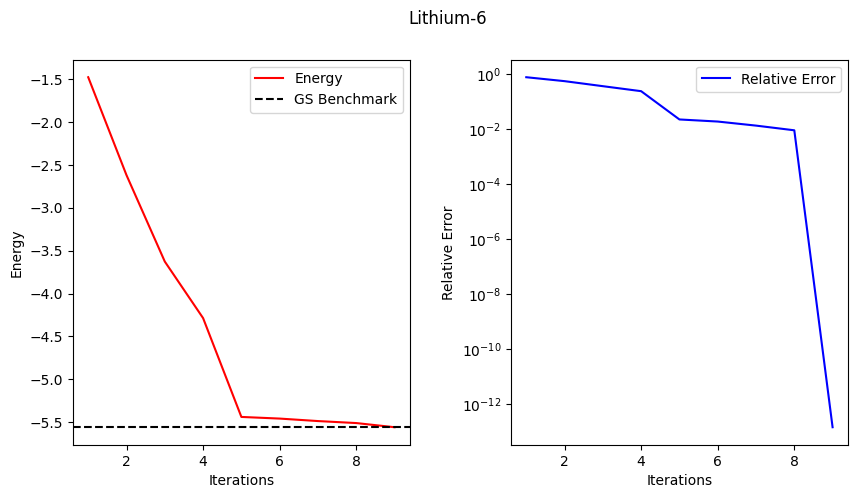

In [107]:
import matplotlib.pyplot as plt
import numpy as np
# Load data from file
data = np.loadtxt(NucleiName + '_ADAPT_VQE_energy.out')

# Extract columns from data
iterations = data[1:,0]
energy = data[1:,1]
rel_error = np.abs(data[1:,2])  # Take the absolute value of the relative error

# Create multiplot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot energy vs. iterations with benchmark on left subplot
ax1.plot(iterations, energy, 'r-', label="Energy")
ax1.axhline(y=GS_benchmark, color='k', linestyle='--', label="GS Benchmark")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Energy")
ax1.legend()
ax1.autoscale_view()  # Adjust axis to the data automatically

# Plot relative error vs. iterations on right subplot
ax2.plot(iterations, rel_error, 'b-', label="Relative Error")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Relative Error")

ax2.set_yscale("log")  # Set the y-axis to log scale
ax2.legend()

# Disable grid and minor ticks
ax2.grid(False)
ax2.minorticks_off()

ax2.autoscale_view()  # Adjust axis to the data automatically

# Add global title
fig.suptitle(NucleiName)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Save plot as PNG
plt.savefig(NucleiName + "_multiplot.png")

# Show the plot
plt.show()

Now we can add this 3 plots in a big multiplot:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh

def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy

# List of nuclei names and their corresponding Hamiltonian files
nuclei_data = {
    "Lithium-6": "hamiltonian_matrix_p_1_1.dat",
    "Beryllium-10": "hamiltonian_matrix_p_2_4.dat",
    "Oxygen-18": "hamiltonian_matrix_2_0.dat"
}

fig, axs = plt.subplots(2, len(nuclei_data), figsize=(15,10))

for i, (nuclei, file) in enumerate(nuclei_data.items()):
    # Load data from file
    data = np.loadtxt(nuclei + '_ADAPT_VQE_energy.out')

    # Extract columns from data
    iterations = data[1:,0]
    energy = data[1:,1]
    rel_error = np.abs(data[1:,2])  # Take the absolute value of the relative error

    # Get the benchmark energy
    GS_benchmark_value = GS_benchmark(file)

    # Plot energy vs. iterations with benchmark on top row
    axs[0, i].plot(iterations, energy, 'r-', label="Energy")
    axs[0, i].axhline(y=GS_benchmark_value, color='k', linestyle='--', label="GS Benchmark")
    axs[0, i].set_xlabel("Iterations")
    axs[0, i].set_ylabel("Energy")
    axs[0, i].legend()
    axs[0, i].autoscale_view()  # Adjust axis to the data automatically

    # Plot relative error vs. iterations on bottom row
    axs[1, i].plot(iterations, rel_error, 'b-', label="Relative Error")
    axs[1, i].set_xlabel("Iterations")
    axs[1, i].set_ylabel("Relative Error")
    axs[1, i].set_yscale("log")  # Set the y-axis to log scale
    axs[1, i].legend()

    # Disable grid and minor ticks
    axs[1, i].grid(False)
    axs[1, i].minorticks_off()

    axs[1, i].autoscale_view()  # Adjust axis to the data automatically

    # Add title for each column
    axs[0, i].set_title(nuclei)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Save plot as PNG
plt.savefig("multiplot.png")

# Show the plot
plt.show()

## 5 - ADAPT-VQE WITH QUANTUM CIRCUIT

In this second part, we will explain how the ADAPT-VQE algorithm is implemented in a quantum circuit. Specifically, in this section, we will obtain the same results that have been previously achieved, but the evolution of the state from $| \psi \rangle$ to $|e^{iT_{rs}^{pq}\theta_k}\psi\rangle$ will be done through a quantum circuit. We will elaborate on the strategy followed to accomplish this state evolution and we will present the circuit that performs this evolution.

In [108]:
from qibo import gates
from qibo.models import Circuit
from openfermion.transforms import jordan_wigner

#### 5.1 - MAPPING:
The first step we must take to implement the circuit is to transform all fermionic operators into Pauli operators. For this, we will use the Jordan-Wigner transformation. This transformation is based on the following relationship:
$$
a_i^{\dagger} = \left(\prod_{k=0}^{i-1} Z_k \right)\sigma_i^{-} \hspace{0.5cm} a_i = \left(\prod_{k=0}^{i-1} Z_k \right)\sigma_i^{+}
$$
In this equation, $\sigma_j^{\pm} = \frac{1}{2}(X_j \pm iY_j)$ where $j$ refers to the specific qubit on which the operator acts.\
With this transformation, the fermionic operators $T_{rs}^{pq}$ can be converted to Pauli strings as follows:
\begin{align*}
    T_{rs}^{pq} &= i(a_p^{\dagger}a_q^{\dagger}a_ra_s-a_r^{\dagger}a_s^{\dagger}a_pa_q)=
    \frac{1}{8}P_{rs}^{pq}\left(-X_pX_qY_rY_s-Y_pY_qY_rY_s+Y_pY_qX_rX_s \right. \nonumber \\
    & \quad \left. + Y_pY_qY_rX_s + Y_pX_qX_rX_s + X_pY_qX_rX_s \right. \left.-X_pX_qY_rX_s-X_pX_qX_rY_s \right)
\end{align*}
Where:
$$
P_{rs}^{pq} = \left(\prod_{m=p+1,m \notin [r,s]}^{q-1}Z_m\right)\left(\prod_{n=r+1,n \notin [p,q]}^{q-1}Z_n\right)
$$

In order to be able to implement this transformation we will use the jordan-wigner transformation of the OpenFermion library

In the following cells we are going to code some functions that are going to be helpfull for the implementation of the algorithm.

In [129]:
def separate_elements(T_qubit_str):
    coefficients = []
    gates = []
    numbers = []

    # Separate individual terms
    terms = re.findall(r'[(]-?[\d.]+[+]?[\d.]+j[)] [\w\d\s\[\]]+', T_qubit_str)

    for term in terms:
        # Extract coefficients
        coeff = re.search(r'[-+]?[\d.]+[+]?[\d.]+j', term)
        coefficients.append(complex(coeff.group()))

        # Extract gates and numbers
        gate_terms = re.findall(r'([XYZ]\d+)', term)
        gates_numbers = [re.split(r'(\d+)', gate_number) for gate_number in gate_terms]

        gates.extend([gn[0] for gn in gates_numbers])
        numbers.extend([int(gn[1]) for gn in gates_numbers])

    return coefficients, gates, numbers

In [130]:
def str_to_gate(string,number):
    if string == 'X':
        gate = gates.X(number)
    elif string == 'Y':
        gate = gates.Y(number)
    elif string == 'Z':
        gate = gates.Z(number)
    elif string == "I":
        gate = gates.I(number)
    return gate

In [131]:
def organize_qbit_gates(qbit_list, unique_numbers):
    """"
    This function recieves a list of gates and a list of unique numbers and returns a list of lists of all the gates we 
    have to implement in each qbit.
    """
    n = len(unique_numbers)
    return [qbit_list[i:i+n] for i in range(0, len(qbit_list), n)]

In [132]:
def unique_elements(input_list):
    """
    This function recieves a list and returns a list with the unique elements of the input list.
    """
    unique_set = set(input_list)
    unique_list = list(unique_set)
    return unique_list

In [133]:
def transform_gates(gates_list):
    """
    This function recieves a list of string gates and returns a list of the gates transformed to implement
    the staircase algorithm.
    """
    transformed_gates = []
    for gate in gates_list:
        if gate == 'X':
            transformed_gates.append('H Z H')
        elif gate == 'Y':
            transformed_gates.append('R1 Z R2')
        else:
            transformed_gates.append(gate)
    return transformed_gates

#### 5.2 INITIAL STATE PREPARATION:
The first step in constructing the circuit is to create the circuit that prepares the initial state. Recall that the default state is $|0\rangle^{\otimes n}$. Therefore, what we need to do is to apply X gates where there is a fermion in the valence space. That is, if we have the initial state [1,2,6,7,8,9], the state corresponds to $|\psi_0 \rangle = |0110001111000\rangle = X_1X_2X_6X_7X_8X_9 |0\rangle ^{\otimes 12}$. So, we will need to add X gates at the qubits 1,2,6,7,8 and 9.

In [134]:
def initial_state(initial_vector,nqubits):
    """
    This function recieves a list of the initial vector and returns a circuit with the initial state.
    """
    qc = Circuit(nqubits)
    qbitbasisvect = [0 for i in range(nqubits)]

    for element in initial_vector:
        qbitbasisvect[element] = 1

    for i in range(nqubits):
        if qbitbasisvect[i] == 1:
            qc.add(gates.X(i))

    print(qc.draw())

    return qc

#### 5.3 EVOLUTION OF THE STATE: STAIRCASE ALGORITHM
In this section, we will explain what the staircase algorithm consists of and how it is implemented in a quantum circuit. Additionally, we will include the function that constructs this circuit.

##### Implementation of $e^{iT_{rs}^{pq}\theta_k}$ Using the Staircase Algorithm 

The Staircase Algorithm is used to construct a quantum circuit that performs the evolution $e^{iT_{rs}^{pq}\theta_k}$. Here's how the algorithm works:

1. **Pauli Strings Containing Only Z Gates:** If the Pauli strings only contain $Z$ gates, the constructed circuit will feature:
   - Two cascades of CNOTs
   - A rotation $R_z(\theta) = e^{-i\frac{\theta}{2}Z}$

2. **Output of Jordan-Wigner Transformation:** The Jordan-Wigner transformation could yield $X$ and $Y$ gates as well. In such a scenario, a basis change is performed:
   - For $X$ gates, the transformation used is $X = HZH$
   - For $Y$ gates, the transformation used is $Y = R_x^{\dagger}Z R_x$

3. **Circuit Construction:** With the above steps, the circuit is built as follows:
   - Initial rotations $H$ and $R_x^{\dagger}$ are applied
   - The first cascade of CNOTs is implemented
   - The $R_z(\theta)$ rotation is performed on the last qubit
   - The second cascade of CNOTs follows
   - Finally, the $H$ and $R_x$ gates are applied to reverse the basis change


##### 3.3.1 Demonstration Staircase Algorithm for 3 qbits.
We will now demonstrate that we can implement the operator U, defined as $U = e^{\theta Z_0Z_1Z_2}$, using the following circuit:

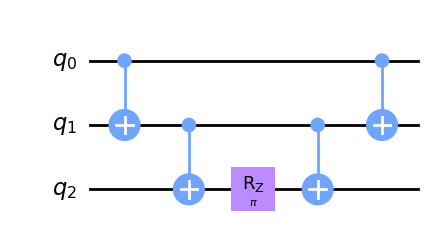

In [135]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_qsphere, circuit_drawer
from math import pi

qc = QuantumCircuit(3)
theta = pi # Define your theta here

qc.cnot(0, 1)
qc.cnot(1, 2)
qc.rz(theta, 2)
qc.cnot(1, 2)
qc.cnot(0, 1)

circuit_drawer(qc, output='mpl')


Firstly, we compute the matrix $U$:
$$
Z \otimes Z \otimes Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} \otimes \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} \otimes \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} = \begin{pmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & -1 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1\end{pmatrix}
$$
$$
    U = \begin{pmatrix} e^{\theta} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & e^{-\theta} & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & e^{-\theta} & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 0 & e^{\theta} & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & e^{-\theta} & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & e^{-\theta} & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & e^{\theta} & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & e^{-\theta}\end{pmatrix}
$$
Next, we compute the matrix associated with the circuit:
$$
(CNOT(0,1)\otimes\mathbf{I}_2) \cdot (\mathbf{I}_2 \otimes CNOT(1,2)) \cdot (\mathbf{I}_2 \otimes \mathbf{I}_2 \otimes R_Z(\theta)) \cdot (\mathbf{I}_2 \otimes CNOT(1,2)) 
$$
Let us now compute the individual terms separately:
$$
(CNOT(0,1)\otimes\mathbf{I}_2) = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 &1 \\ 0 & 0 & 1 &0 \end{pmatrix}  \otimes \mathbf{I}_2 = \begin{pmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\end{pmatrix}
$$
$$
(\mathbf{I}_2 \otimes CNOT(1,2)) = \mathbf{I}_2 \otimes \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 &1 \\ 0 & 0 & 1 &0 \end{pmatrix} =\begin{pmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\end{pmatrix}
$$
$$
(\mathbf{I}_2 \otimes \mathbf{I}_2 \otimes R_Z(\theta)) = \mathbf{I}_2 \otimes \mathbf{I}_2 \otimes e^{\theta Z_3} = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 &0 \\ 0 & 0 & 0 &1 \end{pmatrix}  \otimes \begin{pmatrix} e^{\theta} & 0 \\ 0 & e^{-\theta} \end{pmatrix} =  \begin{pmatrix} e^{\theta} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & e^{-\theta} & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & e^{\theta} & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 0 & e^{-\theta} & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & e^{\theta} & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & e^{-\theta} & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & e^{\theta} & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & e^{-\theta}\end{pmatrix}
$$

We will now compute the matrix multiplication of the first and second matrices:
$$
\begin{aligned}
&(CNOT(0,1)\otimes\mathbf{I}_2) \cdot (\mathbf{I}_2 \otimes CNOT(1,2)) \\
&= \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0
\end{pmatrix} \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1
\end{pmatrix} \\
&= \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0
\end{pmatrix}
\end{aligned}
$$

We also need to compute the product of the second matrix and the first matrix:
$$
\begin{aligned}
&(\mathbf{I}_2 \otimes CNOT(1,2)) \cdot (CNOT(0,1)\otimes\mathbf{I}_2) \\
&= \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1
\end{pmatrix} \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0
\end{pmatrix} \\
&= \begin{pmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
\end{pmatrix}
\end{aligned}
$$
We can now compute the product $(CNOT(0,1)\otimes\mathbf{I}_2) \cdot (\mathbf{I}_2 \otimes CNOT(1,2)) \cdot (\mathbf{I}_2 \otimes \mathbf{I}_2 \otimes R_Z(\theta))$:

$$
\begin{aligned}
    &
    \begin{pmatrix}
        1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
        0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
        0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 1 & 0 & 0
    \end{pmatrix} 
    \begin{pmatrix}
        e^{\theta} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 
        0 & e^{-\theta} & 0 & 0 & 0 & 0 & 0 & 0\\ 
        0 & 0 & e^{\theta} & 0 & 0 & 0 & 0 & 0\\ 
        0 & 0 & 0 & e^{-\theta} & 0 & 0 & 0 & 0 \\ 
        0 & 0 & 0 & 0 & e^{\theta} & 0 & 0 & 0 \\ 
        0 & 0 & 0 & 0 & 0 & e^{-\theta} & 0 & 0 \\ 
        0 & 0 & 0 & 0 & 0 & 0 & e^{\theta} & 0 \\ 
        0 & 0 & 0 & 0 & 0 & 0 & 0 & e^{-\theta}
    \end{pmatrix} \\
    &= \begin{pmatrix} 
        e^{\theta} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 
        0 & e^{-\theta} & 0 & 0 & 0 & 0 & 0 & 0\\ 
        0 & 0 & 0 & e^{-\theta} & 0 & 0 & 0 & 0\\ 
        0 & 0 & e^{\theta} & 0 & 0 & 0 & 0 & 0 \\ 
        0 & 0 & 0 & 0 & 0 & 0 & 0 & e^{-\theta} \\ 
        0 & 0 & 0 & 0 & 0 & 0 & e^{\theta} & 0 \\ 
        0 & 0 & 0 & 0 & e^{\theta} & 0 & 0 & 0 \\ 
        0 & 0 & 0 & 0 & 0 & e^{-\theta} & 0 & 0
    \end{pmatrix}
\end{aligned}
$$
If we finally multiply this matrix with the product of $(\mathbf{I}_2 \otimes CNOT(1,2)) \cdot (CNOT(0,1)\otimes\mathbf{I}_2)$, we obtain:
$$
\begin{aligned}
    &
    \begin{pmatrix} 
        e^{\theta} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 
        0 & e^{-\theta} & 0 & 0 & 0 & 0 & 0 & 0\\ 
        0 & 0 & 0 & e^{-\theta} & 0 & 0 & 0 & 0\\ 
        0 & 0 & e^{\theta} & 0 & 0 & 0 & 0 & 0 \\ 
        0 & 0 & 0 & 0 & 0 & 0 & 0 & e^{-\theta} \\ 
        0 & 0 & 0 & 0 & 0 & 0 & e^{\theta} & 0 \\ 
        0 & 0 & 0 & 0 & e^{\theta} & 0 & 0 & 0 \\ 
        0 & 0 & 0 & 0 & 0 & e^{-\theta} & 0 & 0
    \end{pmatrix}
    \begin{pmatrix}
        1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
        0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
    \end{pmatrix} \\
    &= \begin{pmatrix} e^{\theta} & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & e^{-\theta} & 0 & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & e^{-\theta} & 0 & 0 & 0 & 0 & 0\\ 0 & 0 & 0 & e^{\theta} & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & e^{-\theta} & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & e^{-\theta} & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & e^{\theta} & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & e^{-\theta}\end{pmatrix}
\end{aligned}
$$
Therefore, we recover the same matrix that we had for the expression of the matrix $U$

With all this demonstration, we can now create the function that implements this algorithm for us.

In [136]:
def staircasealgorithm(theta, T, nqubits):
    """"
    Here we implement the Staircase algorithm. We recieve a list of lists of gates, a list of numbers of the qbits, a list of
    coefficients and the number of qbits. We return a list of circuits. This function is used to implement the evolution of
    exp(iTtheta) with a quantum circuit.
    """

    global_circuit = []


    theta = float(theta)
    T_qbits = jordan_wigner(T)
    T_qbits_str = str(T_qbits)

    coef_list, gates_transformed, nums_transformed = separate_elements(T_qbits_str) #we tranform the string to a list of coefficients, gates and numbers
    staircase1 = transform_gates(gates_transformed) #this list has the gates transformed to implement the staircase algorithm. We have to reaorganize it in order to implement it in the quantum circuit.
    number_list = sorted(unique_elements(nums_transformed))
    #number_list = list(number_list.sort()) #list of the unique numbers
    

    qbits_list = organize_qbit_gates(staircase1.copy(), number_list) #this list has the gates transformed and reorganized to implement the staircase algorithm


    for index in range(len(qbits_list)):
        qc = Circuit(nqubits)

        coef = coef_list[index] # We will multiply the RZ gate by this coefficient to get the correct value.

        # Add Hadamard and RX gates at the beginning of the circuit
        for number, gate_string in zip(number_list, qbits_list[index]):
            if gate_string == 'H Z H':
                qc.add(gates.H(number))
            elif gate_string == 'R1 Z R2':
                qc.add(gates.RX(number, -np.pi / 2))

        # Add the main part of the circuit
        for number, gate_string in zip(number_list, qbits_list[index]):
            # Add the cascade of CNOT gates before the RZ gate
            if number != (max(number_list)):
                if gate_string == 'H Z H' or gate_string == 'R1 Z R2' or gate_string == 'Z':
                    index1 = number_list.index(number)
                    qc.add(gates.CNOT(number_list[index1], number_list[index1 + 1]))

            # Add the RZ gate and then the second cascade of CNOT gates
            elif number == (max(number_list)):
                qc.add(gates.RZ(max(number_list), coef * theta))

                for i in reversed(range(1, len(number_list))):
                    qc.add(gates.CNOT(number_list[i - 1], number_list[i]))

        # Add Hadamard and RX gates at the end of the circuit
        for number, gate_string in zip(number_list, qbits_list[index]):
            number = int(number)
            if gate_string == 'H Z H':
                qc.add(gates.H(int(number)))
            elif gate_string == 'R1 Z R2':
                qc.add(gates.RX(int(number), np.pi / 2))

        global_circuit.append(qc)

    
    final_circuit = Circuit(nqubits)

    for circuit in global_circuit:
        for gate in circuit.queue:
            final_circuit.add(gate)

    return final_circuit

Now we are going to program different functions that will be useful to us when building the circuit.

In [137]:
def combined_simulation1(theta, initial_vector_circuit, nqubits, T_OF):

    combined_circuit = Circuit(nqubits)

    main_circuit = staircasealgorithm(theta,T_OF, nqubits)

    # Add gates from the initial state circuit
    for gate1 in initial_vector_circuit.queue:
        combined_circuit.add(gate1)

    # Add gates from the main circuit
    for gate2 in main_circuit.queue:
        combined_circuit.add(gate2)

    # Simulate the combined circuit
    final_state = combined_circuit().state(numpy=True) # Returns in the computational basis
    print(combined_circuit.draw())
    return final_state, combined_circuit

In [138]:
def expected_value1(theta, initial_vector_circuit, hamiltonian, nqubits, T_OF):
    # Pass the initial_vector to the computational basis:

    psi, _ = combined_simulation1(theta, initial_vector_circuit, nqubits, T_OF)

    psic = np.conj(hamiltonian.dot(psi)).transpose()
    #Transform the final_vector to a sparse matrix:

    # Calculate the expectation value
    result = (psic.dot(psi)).real

    return result

In [139]:
def vector_circuit_iteration(thetas_list,list_T,initial_vector_circuit,nqubits):
    """"
    This function recieves a lista of theta's and a list of T's and it returns the corresponding circuit and the corresponding
    vector at the end of the circuit.
    """
    iteration_circuit = Circuit(nqubits)

    #combine all circuits in iteration_circuit into one circuit
    for gate1 in initial_vector_circuit.queue:
        iteration_circuit.add(gate1)
    
    for layer in range(len(thetas_list)):
        circuit_sector = (staircasealgorithm(thetas_list[layer], list_T[layer], nqubits))
        for gate2 in circuit_sector.queue:
            iteration_circuit.add(gate2)

    final_state = iteration_circuit().state(numpy=True)
    final_state_sparse = csr_matrix(final_state).transpose()

    return final_state_sparse, iteration_circuit

In [140]:
def expected_value_iteration(thetas_list,list_T,initial_vector_circuit,hamiltonian,nqubits):
    """"
    This function recieves a list of thetas and a list of T's, and returns the expectation value of the hamiltonian
    """
    psi, _ = vector_circuit_iteration(thetas_list,list_T,initial_vector_circuit,nqubits)
    psic = np.conj(hamiltonian.dot(psi)).transpose()
    #Transform the final_vector to a sparse matrix:

    # Calculate the expectation value
    result = (psic.dot(psi)[0,0]).real

    return result

With all this, we are now ready to build the algorithm by implementing the circuit.

### 6- SIMULATION

#### 6.1 OXYGEN-18: 
Oxygen-18 is composed of 10 neutrons ($N=10$) and 8 protons ($Z=8$). This configuration results in having only 2 neutrons in the valence shell, specifically in the sd-shell, requiring the use of 12 qubits for its simulation.

In [179]:
nqubits = 12
HamiltonianFile ="hamiltonian_matrix_2_0.dat"
FileVectors = "many_body_states_2_0.dat"
epsilon = 0.001
theta_inicial = 0.0

NucleiName = "Oxygen-18"

#--------------------------------------------------------------
with open(FileVectors, 'r') as f:
    lineas = f.readlines()[1:] # omitimos la primera línea
    vectors = [[int(i) for i in linea.split('(')[1].split(')')[0].split(', ')] for linea in lineas]
#--------------------------------------------------------------
NonZeroOperators(vectors,'NonZeroFermionicOperators-QC-O-18.out')
input_file_path = 'NonZeroFermionicOperators-QC-O-18.out'
FileFermionsSwap = 'SwapOperadoresfermionicosnonulos-QC-O-18.out'
swap_elements(input_file_path, FileFermionsSwap)
#--------------------------------------------------------------
H_sparse = transformH(HamiltonianFile, vectors, nqubits)
#--------------------------------------------------------------

Non-zero fermionic operators calculation:  0.2659270763397217
**********************************************************************************************************


In [180]:
def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy
GS_benchmark = GS_benchmark(HamiltonianFile)
print("GS ENERGY:",GS_benchmark)

GS ENERGY: -11.931788251561517


In [181]:
# We start computing the first T that gives the maximum gradient:
energy_list = []

initial_vector, energy_1 = StateMinEnergy2(HamiltonianFile, vectors)
energy_list.append(energy_1)


print(initial_vector)
initial_vector_circuit = initial_state(initial_vector,nqubits) #We have the circuit with the initial state

qbit_basis_vect = [0 if i not in initial_vector.copy() else 1 for i in range(nqubits)]
number = binary_to_decimal(qbit_basis_vect, nqubits)

length = 2**nqubits
initial_vector_comp = csr_matrix(([1], ([number], [0])), shape=(length, 1))

list_theta = []
list_T_OF = []

T_expr1 = FermionOperatorMaxGradient('NonZeroFermionicOperators-QC-O-18.out',FileFermionsSwap,initial_vector_comp,H_sparse,nqubits)[0]
list_T_OF.append(T_expr1)
# Until here we have computed the first operator T that gives the maximum gradient.

[0, 5]
q0 : ─X─
q1 : ───
q2 : ───
q3 : ───
q4 : ───
q5 : ─X─
q6 : ───
q7 : ───
q8 : ───
q9 : ───
q10: ───
q11: ───
[1j [0^ 5^ 8 11] +
(-0-1j) [8^ 11^ 0 5]]


In [182]:
# Now we have to compute the first theta that gives the minimum energy and the value of the energy

res = minimize(lambda theta: expected_value1(theta, initial_vector_circuit, H_sparse, nqubits, T_expr1),
               [theta_inicial], method='BFGS')

theta1 = res.x[0]
print("Theta value:",theta1)
list_theta.append(theta1)

print(list_theta)

energy = res.fun
energy_list.append(energy)
print("Energy_value:",energy)

q0 :     ─X──H─o────────────────────────────────────o─H──H──o────────────────── ...
q1 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
q2 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
q3 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
q4 :     ────────────X─o────────────────────o─X───────────────────X─o────────── ...
q5 :     ─X──H─────────X─o────────────────o─X─────────H──H──────────X─o──────── ...
q6 :     ────────────────|────────────────|───────────────────────────|──────── ...
q7 :     ────────────────|────────────────|───────────────────────────|──────── ...
q8 :     ─H──────────────X─o────────────o─X───────────H──RX───────────X─o────── ...
q9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
q10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
q11:     ─RX───────────────────X─RZ─X─────────────────RX─H──────────────────

In [183]:
vect_comp_T, vect_T_circuit = combined_simulation1(theta1, initial_vector_circuit, nqubits, T_expr1)
vect_comp_T = csr_matrix(vect_comp_T).transpose()

q0 :     ─X──H─o────────────────────────────────────o─H──H──o────────────────── ...
q1 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
q2 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
q3 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
q4 :     ────────────X─o────────────────────o─X───────────────────X─o────────── ...
q5 :     ─X──H─────────X─o────────────────o─X─────────H──H──────────X─o──────── ...
q6 :     ────────────────|────────────────|───────────────────────────|──────── ...
q7 :     ────────────────|────────────────|───────────────────────────|──────── ...
q8 :     ─H──────────────X─o────────────o─X───────────H──RX───────────X─o────── ...
q9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
q10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
q11:     ─RX───────────────────X─RZ─X─────────────────RX─H──────────────────

In [184]:
# ITERATION
iteracio = 1
while (abs(GS_benchmark)-abs(energy)) > epsilon:
    # Now we compute the next iteration of the algorithm:
    print("#-------------------------------------------------------")
    print("iteració:", iteracio)

    T_expr = FermionOperatorMaxGradient('NonZeroFermionicOperators-QC-O-18.out',FileFermionsSwap,vect_comp_T,H_sparse,nqubits)[0]
    list_T_OF.append(T_expr)

    res = minimize(lambda thetas: expected_value_iteration(thetas,list_T_OF,initial_vector_circuit, H_sparse, nqubits),
               list_theta + [theta_inicial], method='BFGS',tol = 10**(-8))

    list_theta = list(res.x)
    print(list_theta)

    energy = res.fun
    energy_list.append(energy)
    print(energy)

    # Now we compute the new vector:

    vect_comp_T, vect_T_circuit = vector_circuit_iteration(list_theta,list_T_OF,initial_vector_circuit,nqubits)
    print(vect_T_circuit.draw())
    #print(vect_comp_T)
    iteracio = iteracio + 1

#-------------------------------------------------------
iteració: 1
[1j [0^ 5^ 6 7] +
(-0-1j) [6^ 7^ 0 5]]
[-0.30455642711456793, -0.9460169941025529]
-10.109052363811744
q0 :     ─X──H─o────────────────────────────────────o─H──H──o────────────────── ...
q1 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
q2 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
q3 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
q4 :     ────────────X─o────────────────────o─X───────────────────X─o────────── ...
q5 :     ─X──H─────────X─o────────────────o─X─────────H──H──────────X─o──────── ...
q6 :     ────────────────|────────────────|───────────────────────────|──────── ...
q7 :     ────────────────|────────────────|───────────────────────────|──────── ...
q8 :     ─H──────────────X─o────────────o─X───────────H──RX───────────X─o────── ...
q9 :     ──────────────────X─o────────o─X───────────────────────────────

With this we have reached the same result that we had obtained in the previous section:

$$
|\psi_{^{18} \text{O}} \rangle = e^{i\theta_4 T_{2,3}^{0,5}}e^{i\theta_3 T_{9,10}^{0,5}}e^{i\theta_2 T_{1,4}^{0,5}}e^{i\theta_1 T_{6,7}^{0,5}}e^{i\theta_0 T_{8,11}^{0,5}}X_0X_5|0\rangle^{\otimes 12}
$$

The associated values are as follows: $\theta_0$ = -0.15726, $\theta_1=$ -0.43724, $\theta_2$=0.60466, $\theta_3 =$ 0.21443, $\theta_4 =$ -0.78547.

Now we save the data:

In [185]:
# NOW WE SAVE THE RESULTS
# iteration_list:
iteration_list = []
for i in range(len(energy_list)):
    iteration_list.append(i)

with open(NucleiName + '_QUANTUM-CIRCUIT-ADAPT_VQE_energy.out', 'w') as f:
    for i, energy in zip(iteration_list, energy_list):
        rel_error = abs((energy - GS_benchmark) / GS_benchmark)
        f.write(str(i) + ' ' + str(energy) + ' ' + str(rel_error) + '\n')
#----------------------------------------------------------------------------------------------------
# Now we save all the theta values on a file:
print(list_theta)
with open(NucleiName + 'QUANTUM-CIRCUIT_theta_values.out', 'w') as f:
    for theta in list_theta:
        f.write(str(theta) + '\n')

[-0.31453341975360233, -0.8743331056414285, 1.2092097095536545, 0.4287833338300505, -1.5707970869263677]


And finally we plot the results:

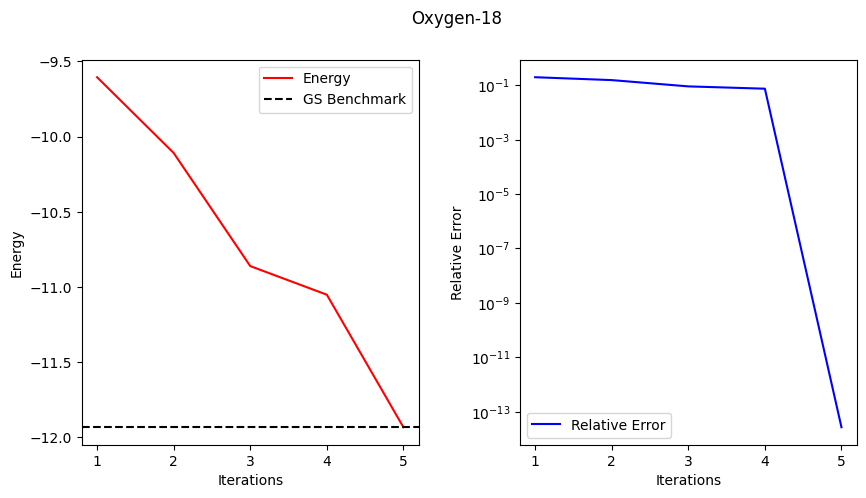

In [186]:
import matplotlib.pyplot as plt
import numpy as np
# Load data from file
data = np.loadtxt(NucleiName + '_QUANTUM-CIRCUIT-ADAPT_VQE_energy.out')

# Extract columns from data
iterations = data[1:,0]
energy = data[1:,1]
rel_error = np.abs(data[1:,2])  # Take the absolute value of the relative error

# Create multiplot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot energy vs. iterations with benchmark on left subplot
ax1.plot(iterations, energy, 'r-', label="Energy")
ax1.axhline(y=GS_benchmark, color='k', linestyle='--', label="GS Benchmark")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Energy")
ax1.legend()
ax1.autoscale_view()  # Adjust axis to the data automatically

# Plot relative error vs. iterations on right subplot
ax2.plot(iterations, rel_error, 'b-', label="Relative Error")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Relative Error")

ax2.set_yscale("log")  # Set the y-axis to log scale
ax2.legend()

# Disable grid and minor ticks
ax2.grid(False)
ax2.minorticks_off()

ax2.autoscale_view()  # Adjust axis to the data automatically

# Add global title
fig.suptitle(NucleiName)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Save plot as PNG
plt.savefig(NucleiName + "QC_multiplot.png")

# Show the plot
plt.show()

#### 6.2 BERILYIUM-10:  
Beryllium-10 is composed of 6 neutrons ($N=6$) and 4 protons ($Z=4$). Consequently, we have 4 neutrons and 2 protons in the valence shell, necessitating the use of 12 qubits for the simulation within the p-shell

In [159]:
nqubits = 12
HamiltonianFile ="hamiltonian_matrix_p_2_4.dat"
FileVectors = "many_body_states_p_2_4.dat"
epsilon = 0.001
theta_inicial = 0.0

NucleiName = "Beryllium-10"

#--------------------------------------------------------------
with open(FileVectors, 'r') as f:
    lineas = f.readlines()[1:] # omitimos la primera línea
    vectors = [[int(i) for i in linea.split('(')[1].split(')')[0].split(', ')] for linea in lineas]
#--------------------------------------------------------------
NonZeroOperators(vectors,'NonZeroFermionicOperators-QC-Be-10.out')
input_file_path = 'NonZeroFermionicOperators-QC-Be-10.out'
FileFermionsSwap = 'SwapOperadoresfermionicosnonulos-QC-Be-10.out'
swap_elements(input_file_path, FileFermionsSwap)
#--------------------------------------------------------------
H_sparse = transformH(HamiltonianFile, vectors, nqubits)
#--------------------------------------------------------------

Non-zero fermionic operators calculation:  6.097007513046265
**********************************************************************************************************


In [160]:
def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy
GS_benchmark = GS_benchmark(HamiltonianFile)
print("GS ENERGY:",GS_benchmark)

GS ENERGY: -39.45341579805709


In [161]:
# We start computing the first T that gives the maximum gradient:
energy_list = []

initial_vector, energy_1 = StateMinEnergy2(HamiltonianFile, vectors)
energy_list.append(energy_1)


print(initial_vector)
initial_vector_circuit = initial_state(initial_vector,nqubits) #We have the circuit with the initial state

qbit_basis_vect = [0 if i not in initial_vector.copy() else 1 for i in range(nqubits)]
number = binary_to_decimal(qbit_basis_vect, nqubits)

length = 2**nqubits
initial_vector_comp = csr_matrix(([1], ([number], [0])), shape=(length, 1))

list_theta = []
list_T_OF = []

T_expr1 = FermionOperatorMaxGradient('NonZeroFermionicOperators-QC-Be-10.out',FileFermionsSwap,initial_vector_comp,H_sparse,nqubits)[0]
list_T_OF.append(T_expr1)
# Until here we have computed the first operator T that gives the maximum gradient.

[1, 2, 6, 7, 8, 9]
q0 : ───
q1 : ─X─
q2 : ─X─
q3 : ───
q4 : ───
q5 : ───
q6 : ─X─
q7 : ─X─
q8 : ─X─
q9 : ─X─
q10: ───
q11: ───
[(-0-1j) [1^ 2^ 4 5] +
1j [4^ 5^ 1 2], (-0-1j) [6^ 9^ 10 11] +
1j [10^ 11^ 6 9], (-0-1j) [7^ 8^ 10 11] +
1j [10^ 11^ 7 8]]


In [162]:
# Now we have to compute the first theta that gives the minimum energy and the value of the energy

res = minimize(lambda theta: expected_value1(theta, initial_vector_circuit, H_sparse, nqubits, T_expr1),
               [theta_inicial], method='BFGS')

theta1 = res.x[0]
print("Theta value:",theta1)
list_theta.append(theta1)

print(list_theta)

energy = res.fun
energy_list.append(energy)
print("Energy_value:",energy)

q0 :     ────────────────────────────────────────────────────────────────────── ...
q1 :     ─X──H─o────────────o─H──H──o────────────o─H──H──o────────────o─H──H──o ...
q2 :     ─X──H─X─o────────o─X─H──H──X─o────────o─X─H──RX─X─o────────o─X─RX─RX─X ...
q3 :     ────────|────────|───────────|────────|───────────|────────|────────── ...
q4 :     ─H──────X─o────o─X───H──RX───X─o────o─X───RX─H────X─o────o─X───H──RX── ...
q5 :     ─RX───────X─RZ─X─────RX─H──────X─RZ─X─────H──H──────X─RZ─X─────H──RX── ...
q6 :     ─X──────────────────────────────────────────────────────────────────── ...
q7 :     ─X──────────────────────────────────────────────────────────────────── ...
q8 :     ─X──────────────────────────────────────────────────────────────────── ...
q9 :     ─X──────────────────────────────────────────────────────────────────── ...
q10:     ────────────────────────────────────────────────────────────────────── ...
q11:     ───────────────────────────────────────────────────────────────────

In [187]:
vect_comp_T, vect_T_circuit = combined_simulation1(theta1, initial_vector_circuit, nqubits, T_expr1)
vect_comp_T = csr_matrix(vect_comp_T).transpose()

q0 :     ─X──H─o────────────────────────────────────o─H──H──o────────────────── ...
q1 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
q2 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
q3 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
q4 :     ────────────X─o────────────────────o─X───────────────────X─o────────── ...
q5 :     ─X──H─────────X─o────────────────o─X─────────H──H──────────X─o──────── ...
q6 :     ────────────────|────────────────|───────────────────────────|──────── ...
q7 :     ────────────────|────────────────|───────────────────────────|──────── ...
q8 :     ─H──────────────X─o────────────o─X───────────H──RX───────────X─o────── ...
q9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
q10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
q11:     ─RX───────────────────X─RZ─X─────────────────RX─H──────────────────

In [ ]:
# ITERATION
iteracio = 1
while (abs(GS_benchmark)-abs(energy)) > epsilon:
    # Now we compute the next iteration of the algorithm:
    print("#-------------------------------------------------------")
    print("iteració:", iteracio)

    T_expr = FermionOperatorMaxGradient('NonZeroFermionicOperators-QC-Be-10.out',FileFermionsSwap,vect_comp_T,H_sparse,nqubits)[0]
    list_T_OF.append(T_expr)

    res = minimize(lambda thetas: expected_value_iteration(thetas,list_T_OF,initial_vector_circuit, H_sparse, nqubits),
               list_theta + [theta_inicial], method='BFGS',tol = 10**(-8))

    list_theta = list(res.x)
    print(list_theta)

    energy = res.fun
    energy_list.append(energy)
    print(energy)

    # Now we compute the new vector:

    vect_comp_T, vect_T_circuit = vector_circuit_iteration(list_theta,list_T_OF,initial_vector_circuit,nqubits)
    print(vect_T_circuit.draw())
    #print(vect_comp_T)
    iteracio = iteracio + 1

Now we save the data

In [ ]:
# NOW WE SAVE THE RESULTS
# iteration_list:
iteration_list = []
for i in range(len(energy_list)):
    iteration_list.append(i)

with open(NucleiName + '_QUANTUM-CIRCUIT-ADAPT_VQE_energy.out', 'w') as f:
    for i, energy in zip(iteration_list, energy_list):
        rel_error = abs((energy - GS_benchmark) / GS_benchmark)
        f.write(str(i) + ' ' + str(energy) + ' ' + str(rel_error) + '\n')
#----------------------------------------------------------------------------------------------------
# Now we save all the theta values on a file:
print(list_theta)
with open(NucleiName + 'QUANTUM-CIRCUIT_theta_values.out', 'w') as f:
    for theta in list_theta:
        f.write(str(theta) + '\n')

And finally plot the results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Load data from file
data = np.loadtxt(NucleiName + '_QUANTUM-CIRCUIT-ADAPT_VQE_energy.out')

# Extract columns from data
iterations = data[1:,0]
energy = data[1:,1]
rel_error = np.abs(data[1:,2])  # Take the absolute value of the relative error

# Create multiplot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot energy vs. iterations with benchmark on left subplot
ax1.plot(iterations, energy, 'r-', label="Energy")
ax1.axhline(y=GS_benchmark, color='k', linestyle='--', label="GS Benchmark")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Energy")
ax1.legend()
ax1.autoscale_view()  # Adjust axis to the data automatically

# Plot relative error vs. iterations on right subplot
ax2.plot(iterations, rel_error, 'b-', label="Relative Error")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Relative Error")

ax2.set_yscale("log")  # Set the y-axis to log scale
ax2.legend()

# Disable grid and minor ticks
ax2.grid(False)
ax2.minorticks_off()

ax2.autoscale_view()  # Adjust axis to the data automatically

# Add global title
fig.suptitle(NucleiName)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Save plot as PNG
plt.savefig(NucleiName + "QC_multiplot.png")

# Show the plot
plt.show()

#### 6.3 LITHIUM-6:  
Lithium-6 is constituted by 3 neutrons (N=3) and 3 protons (Z=3), consequently, we have 1 neutron and 1 proton in the valence shell, situating us within the p-shell and requiring 12 qubits.

In [192]:
nqubits = 12
HamiltonianFile ="hamiltonian_matrix_p_1_1.dat"
FileVectors = "many_body_states_p_1_1.dat"
epsilon = 0.001
theta_inicial = 0.0

NucleiName = "Lithium-6"

#--------------------------------------------------------------
with open(FileVectors, 'r') as f:
    lineas = f.readlines()[1:] # omitimos la primera línea
    vectors = [[int(i) for i in linea.split('(')[1].split(')')[0].split(', ')] for linea in lineas]
#--------------------------------------------------------------
NonZeroOperators(vectors,'NonZeroFermionicOperators-QC-Li-6.out')
input_file_path = 'NonZeroFermionicOperators-QC-Li-6.out'
FileFermionsSwap = 'SwapOperadoresfermionicosnonulos-QC-Li-6.out'
swap_elements(input_file_path, FileFermionsSwap)
#--------------------------------------------------------------
H_sparse = transformH(HamiltonianFile, vectors, nqubits)
#--------------------------------------------------------------

Non-zero fermionic operators calculation:  0.26400184631347656
**********************************************************************************************************


In [193]:
def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy
GS_benchmark = GS_benchmark(HamiltonianFile)
print("GS ENERGY:",GS_benchmark)

GS ENERGY: -5.5567832187164745


The minimum energy state of the Hamiltonian, $|\psi_0\rangle = a_2^{\dagger}a_7^{\dagger}|\text{vac}\rangle$ causes the algorithm to stagnate in a local minimum. To circumvent this, we initialize the system from another state, $|\psi_0 \rangle = a_1^{\dagger}a_{11}^{\dagger}|\text{vac}\rangle$

In [194]:
# We start computing the first T that gives the maximum gradient:
energy_list = []

_, energy_1 = StateMinEnergy2(HamiltonianFile, vectors)
energy_list.append(energy_1)

initial_vector = [1,11]
print(initial_vector)
initial_vector_circuit = initial_state(initial_vector,nqubits) #We have the circuit with the initial state

qbit_basis_vect = [0 if i not in initial_vector.copy() else 1 for i in range(nqubits)]
number = binary_to_decimal(qbit_basis_vect, nqubits)

length = 2**nqubits
initial_vector_comp = csr_matrix(([1], ([number], [0])), shape=(length, 1))

list_theta = []
list_T_OF = []

T_expr1 = FermionOperatorMaxGradient('NonZeroFermionicOperators-QC-Li-6.out',FileFermionsSwap,initial_vector_comp,H_sparse,nqubits)[0]
list_T_OF.append(T_expr1)
# Until here we have computed the first operator T that gives the maximum gradient.

[1, 11]
q0 : ───
q1 : ─X─
q2 : ───
q3 : ───
q4 : ───
q5 : ───
q6 : ───
q7 : ───
q8 : ───
q9 : ───
q10: ───
q11: ─X─
[1j [1^ 11^ 5 7] +
(-0-1j) [5^ 7^ 1 11]]


In [195]:
# Now we have to compute the first theta that gives the minimum energy and the value of the energy

res = minimize(lambda theta: expected_value1(theta, initial_vector_circuit, H_sparse, nqubits, T_expr1),
               [theta_inicial], method='BFGS')

theta1 = res.x[0]
print("Theta value:",theta1)
list_theta.append(theta1)

print(list_theta)

energy = res.fun
energy_list.append(energy)
print("Energy_value:",energy)

q0 :     ────────────────────────────────────────────────────────────────────── ...
q1 :     ─X─H──o────────────────────────────────────o─H──H──o────────────────── ...
q2 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
q3 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
q4 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
q5 :     ─H──────────X─o────────────────────o─X───────H──H────────X─o────────── ...
q6 :     ──────────────|────────────────────|───────────────────────|────────── ...
q7 :     ─H────────────X─o────────────────o─X─────────H──RX─────────X─o──────── ...
q8 :     ────────────────X─o────────────o─X───────────────────────────X─o────── ...
q9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
q10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
q11:     ─X─RX─────────────────X─RZ─X─────────────────RX─H──────────────────

In [196]:
vect_comp_T, vect_T_circuit = combined_simulation1(theta1, initial_vector_circuit, nqubits, T_expr1)
vect_comp_T = csr_matrix(vect_comp_T).transpose()

q0 :     ────────────────────────────────────────────────────────────────────── ...
q1 :     ─X─H──o────────────────────────────────────o─H──H──o────────────────── ...
q2 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
q3 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
q4 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
q5 :     ─H──────────X─o────────────────────o─X───────H──H────────X─o────────── ...
q6 :     ──────────────|────────────────────|───────────────────────|────────── ...
q7 :     ─H────────────X─o────────────────o─X─────────H──RX─────────X─o──────── ...
q8 :     ────────────────X─o────────────o─X───────────────────────────X─o────── ...
q9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
q10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
q11:     ─X─RX─────────────────X─RZ─X─────────────────RX─H──────────────────

In [197]:
# ITERATION
iteracio = 1
while (abs(GS_benchmark)-abs(energy)) > epsilon:
    # Now we compute the next iteration of the algorithm:
    print("#-------------------------------------------------------")
    print("iteració:", iteracio)

    T_expr = FermionOperatorMaxGradient('NonZeroFermionicOperators-QC-Li-6.out',FileFermionsSwap,vect_comp_T,H_sparse,nqubits)[0]
    list_T_OF.append(T_expr)

    res = minimize(lambda thetas: expected_value_iteration(thetas,list_T_OF,initial_vector_circuit, H_sparse, nqubits),
               list_theta + [theta_inicial], method='BFGS',tol = 10**(-8))

    list_theta = list(res.x)
    print(list_theta)

    energy = res.fun
    energy_list.append(energy)
    print(energy)

    # Now we compute the new vector:

    vect_comp_T, vect_T_circuit = vector_circuit_iteration(list_theta,list_T_OF,initial_vector_circuit,nqubits)
    print(vect_T_circuit.draw())
    #print(vect_comp_T)
    iteracio = iteracio + 1

#-------------------------------------------------------
iteració: 1
[1j [1^ 11^ 3 6] +
(-0-1j) [3^ 6^ 1 11]]
[-1.192458635993678, 1.3344768173748747]
-2.621380222756075
q0 :     ────────────────────────────────────────────────────────────────────── ...
q1 :     ─X─H──o────────────────────────────────────o─H──H──o────────────────── ...
q2 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
q3 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
q4 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
q5 :     ─H──────────X─o────────────────────o─X───────H──H────────X─o────────── ...
q6 :     ──────────────|────────────────────|───────────────────────|────────── ...
q7 :     ─H────────────X─o────────────────o─X─────────H──RX─────────X─o──────── ...
q8 :     ────────────────X─o────────────o─X───────────────────────────X─o────── ...
q9 :     ──────────────────X─o────────o─X───────────────────────────────X─

Now we save the data:

In [223]:
# NOW WE SAVE THE RESULTS
# iteration_list:
iteration_list = []
for i in range(len(energy_list)):
    iteration_list.append(i)

with open(NucleiName + '_QUANTUM-CIRCUIT-ADAPT_VQE_energy.out', 'w') as f:
    for i, energy in zip(iteration_list, energy_list):
        rel_error = abs((energy - GS_benchmark) / GS_benchmark)
        f.write(str(i) + ' ' + str(energy) + ' ' + str(rel_error) + '\n')
#----------------------------------------------------------------------------------------------------
# Now we save all the theta values on a file:
print(list_theta)
with open(NucleiName + 'QUANTUM-CIRCUIT_theta_values.out', 'w') as f:
    for theta in list_theta:
        f.write(str(theta) + '\n')

[-0.8873656294665531, 0.8909781264060053, -1.0232263540065312, 1.230959399969343, 1.5707957844097191, -0.32977572390900484, -0.3343553837870997, 0.596709943041437, 0.6434990495849092]


And finally we plot the results:

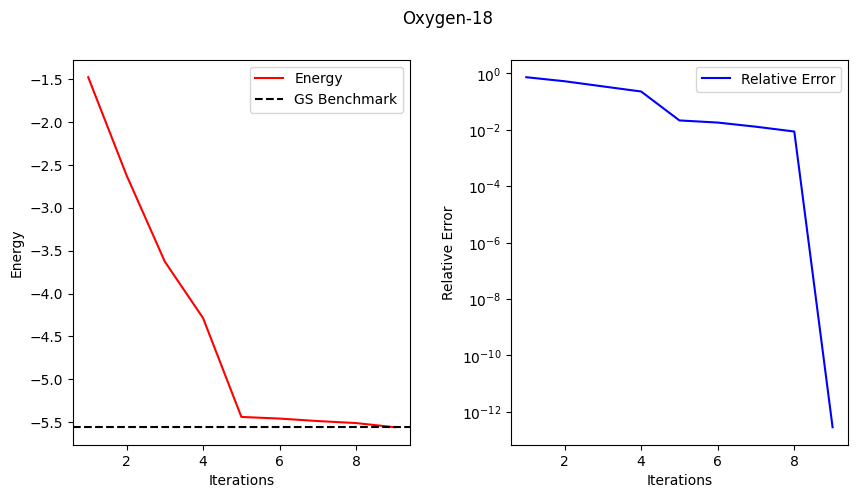

In [224]:
import matplotlib.pyplot as plt
import numpy as np
# Load data from file
data = np.loadtxt(NucleiName + '_QUANTUM-CIRCUIT-ADAPT_VQE_energy.out')

# Extract columns from data
iterations = data[1:,0]
energy = data[1:,1]
rel_error = np.abs(data[1:,2])  # Take the absolute value of the relative error

# Create multiplot with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot energy vs. iterations with benchmark on left subplot
ax1.plot(iterations, energy, 'r-', label="Energy")
ax1.axhline(y=GS_benchmark, color='k', linestyle='--', label="GS Benchmark")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Energy")
ax1.legend()
ax1.autoscale_view()  # Adjust axis to the data automatically

# Plot relative error vs. iterations on right subplot
ax2.plot(iterations, rel_error, 'b-', label="Relative Error")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Relative Error")

ax2.set_yscale("log")  # Set the y-axis to log scale
ax2.legend()

# Disable grid and minor ticks
ax2.grid(False)
ax2.minorticks_off()

ax2.autoscale_view()  # Adjust axis to the data automatically

# Add global title
fig.suptitle(NucleiName)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Save plot as PNG
plt.savefig(NucleiName + "QC_multiplot.png")

# Show the plot
plt.show()

Code of the multiplot added on the bachelor thesis:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh

def GS_benchmark(FileHamiltonian):
    # Read data from file
    with open(FileHamiltonian, "r") as f:
        data = np.loadtxt(f)

    # Construct sparse matrix from data
    hamiltonian = coo_matrix((data[:, 2], (data[:, 0].astype(int), data[:, 1].astype(int))))

    # Diagonalize Hamiltonian matrix and compute ground state energy
    evals, evecs = eigsh(hamiltonian, k=1, which="SA")
    ground_state_energy = evals[0]

    return ground_state_energy

# List of nuclei names and their corresponding Hamiltonian files
nuclei_data = {
    "Lithium-6": "hamiltonian_matrix_p_1_1.dat",
    "Beryllium-10": "hamiltonian_matrix_p_2_4.dat",
    "Oxygen-18": "hamiltonian_matrix_2_0.dat"
}

fig, axs = plt.subplots(2, len(nuclei_data), figsize=(15,10))

for i, (nuclei, file) in enumerate(nuclei_data.items()):
    # Load data from file
    data = np.loadtxt(nuclei + '_ADAPT_VQE_energy.out')

    # Extract columns from data
    iterations = data[1:,0]
    energy = data[1:,1]
    rel_error = np.abs(data[1:,2])  # Take the absolute value of the relative error

    # Get the benchmark energy
    GS_benchmark_value = GS_benchmark(file)

    # Plot energy vs. iterations with benchmark on top row
    axs[0, i].plot(iterations, energy, 'r-', label="Energy")
    axs[0, i].axhline(y=GS_benchmark_value, color='k', linestyle='--', label="GS Benchmark")
    axs[0, i].set_xlabel("Iterations")
    axs[0, i].set_ylabel("Energy (MeV)")
    axs[0, i].legend()
    axs[0, i].autoscale_view()  # Adjust axis to the data automatically

    # Plot relative error vs. iterations on bottom row
    axs[1, i].plot(iterations, rel_error, 'b-', label="Relative Error")
    axs[1, i].set_xlabel("Iterations")
    axs[1, i].set_ylabel("Relative Error")
    axs[1, i].set_yscale("log")  # Set the y-axis to log scale
    axs[1, i].legend()

    # Disable grid and minor ticks
    axs[1, i].grid(False)
    axs[1, i].minorticks_off()

    axs[1, i].autoscale_view()  # Adjust axis to the data automatically

    # Add title for each column
    axs[0, i].set_title(nuclei)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Save plot as PNG
plt.savefig("multiplot.png")

# Show the plot
plt.show()

### 7- EXPECTATION VALUE

In this section, we will delve into the method of estimating the expected value by carrying out measurements on a quantum circuit. This vital step allows us to extract tangible results from our quantum simulations.

To illuminate this process, we'll present a specific example involving the sd-shell Hamiltonian for Oxygen-18.

Given the probabilistic essence of quantum mechanics, we'll also compare the standard deviation of our results as a function of the number of calculation repetitions. This analysis will provide insight into the variability of our results and the stability of our quantum simulation.

Remember that our results are intrinsically probabilistic. This inherent stochasticity underscores the need for running multiple simulations and averaging results to achieve reliable outcomes.

This section outlines the computation of the expectation value $\langle \psi(\boldsymbol{\theta})|H_{\text{eff}}|\psi(\boldsymbol{\theta})\rangle$ given the evolved circuit $|\psi(\boldsymbol{\theta})\rangle$. 

The Hamiltonian is decomposed into four terms. 

1. Single-body operators $n_i$, which become diagonal post-Jordan-Wigner transformation, can be measured directly. With $p_1^{(i)}$ as the probability of measuring 1 in the $i$-th qubit, we have: 

    $$
    \langle \psi_n|n_i|\psi_n\rangle = \frac{1}{2}\langle \psi_n|1-Z_i|\psi_n\rangle = p_1^{(i)}
    $$
   
2. Two-body Hamiltonian terms are further divided into three types:
    
    - $h_{ijij}$ operator, the product of two single-body operators. If $p_{11}^{(ij)}$ is the probability of measuring 1 in qubits $i$ and $j$, we have:

        $$
        \langle \psi_n|h_{ijij}|\psi_n\rangle = -2p_{11}^{(ij)}
        $$
    
    - $h_{ijik}$ operator, which can be disentangled using basis change with $M_{jk} = CX_{kj}H_{k}CX_{kj}$:

        $$
        \langle \psi_n|h_{ijik}|\psi_n\rangle = p_{101}^{(ijk)}-p_{110}^{(ijk)}
        $$
   
    - $h_{ijkl}$ operator, disentangled with basis change $M_{ijkl} = CX_{ij}CX_{ki}CX_{lk}H_lCX_{lk}CX_{ki}CX_{ij}$:

        $$
        \langle \psi_n|h_{ijkl}|\psi_n\rangle = p_{1100}^{(ijkl)}-p_{0011}^{(ijkl)}
        $$

Here, $p_{r_1\dots r_k}^{q_1\dots q_k}$ denote the probabilities of measuring $r_1 \dots r_k$ in the qubits $q_1 \dots q_k$ after the basis change.


In [225]:
# Now we are going to code some functions that will hekp us to compute the expectation value
def extract_terms(file_path):
    with open(file_path, 'r') as file:
        file_content = file.read()

    FO_onebodyterms = []
    coef_onebodyterms = []

    hijij_FO_terms = []
    coef_hijij_terms = []

    hijik_FO_terms = []
    coef_h_ijik_terms = []

    hijkl_FO_terms = []
    coef_h_ijkl_terms = []

    M_jk_numbers = []
    M_ijkl_numbers = []

    # ONEBODY TERMS
    onebody_terms = re.findall(r'\d+\.\d+\s\[\d+\^\s\d+\]', file_content)
    for term_ob in onebody_terms:
        coeff, i, j = term_ob.split()
        FO_onebodyterms.append(f'{i} {j}')
        coef_onebodyterms.append(float(coeff))

    # TWOBODY TERMS
    for m in re.finditer(r'(\d+\.\d+)\s\[(\d+)\^\s(\d+)\^\s(\d+)\s(\d+)\]', file_content):
        coeff, i, j, k, l = m.groups()
        # h_ijij TERMS:
        if i == k and j == l:
            hijij_FO_terms.append(f'[{i}^ {j}^ {k} {l}]')
            coef_hijij_terms.append(float(coeff))
        # h_ijik TERMS:
        elif i == k and j != l:
            M_jk_numbers.append([j, l])
            hijik_FO_terms.append(f'[{i}^ {j}^ {k} {l}]')
            coef_h_ijik_terms.append(float(coeff))
        elif i != k and j == l:
            M_jk_numbers.append([i, k])
            hijik_FO_terms.append(f'[{i}^ {j}^ {k} {l}]')
            coef_h_ijik_terms.append(float(coeff))
        elif i == j and k != l:
            M_jk_numbers.append([k, l])
            hijik_FO_terms.append(f'[{i}^ {j}^ {k} {l}]')
            coef_h_ijik_terms.append(float(coeff))
        elif i != j and k == l:
            M_jk_numbers.append([i, j])
            hijik_FO_terms.append(f'[{i}^ {j}^ {k} {l}]')
            coef_h_ijik_terms.append(float(coeff))
        elif i == l and j != k:
            M_jk_numbers.append([j, k])
            hijik_FO_terms.append(f'[{i}^ {j}^ {k} {l}]')
            coef_h_ijik_terms.append(float(coeff))
        elif i != l and j == k:
            M_jk_numbers.append([i, l])
            hijik_FO_terms.append(f'[{i}^ {j}^ {k} {l}]')
            coef_h_ijik_terms.append(float(coeff))
        # h_ijkl TERMS:
        elif i != k and i != j and i != l and j != k and j != l and k != l:
            M_ijkl_numbers.append([i, j, k, l])
            hijkl_FO_terms.append(f'[{i}^ {j}^ {k} {l}]')
            coef_h_ijkl_terms.append(float(coeff))

    return (
        coef_onebodyterms, FO_onebodyterms,
        coef_hijij_terms, hijij_FO_terms,
        coef_h_ijik_terms, hijik_FO_terms,
        coef_h_ijkl_terms, hijkl_FO_terms,
        M_jk_numbers, M_ijkl_numbers
    )

def str_to_gate(string,number):
    if string == 'X':
        gate = gates.X(number)
    elif string == 'Y':
        gate = gates.Y(number)
    elif string == 'Z':
        gate = gates.Z(number)
    elif string == 'I':
        gate = gates.I(number)
    return gate

In this case we are only to compute the expectation value for the Oxygen-18

In [226]:
nqubits = 12
HamiltonianFile ="hamiltonian_matrix_2_0.dat"
FileVectors = "many_body_states_2_0.dat"


# This hamiltonian is the same one that we wrote before but transformed to Fermionic Operators
HamiltonianFileFO = "ham_sd_12qb.dat"

epsilon = 0.001
theta_inicial = 0.0

NucleiName = "Oxygen-18"

#--------------------------------------------------------------
with open(FileVectors, 'r') as f:
    lineas = f.readlines()[1:] # omitimos la primera línea
    vectors = [[int(i) for i in linea.split('(')[1].split(')')[0].split(', ')] for linea in lineas]
#--------------------------------------------------------------
NonZeroOperators(vectors,'NonZeroFermionicOperators-QC-O-18.out')
input_file_path = 'NonZeroFermionicOperators-QC-O-18.out'
FileFermionsSwap = 'SwapOperadoresfermionicosnonulos-QC-O-18.out'
swap_elements(input_file_path, FileFermionsSwap)
#--------------------------------------------------------------
H_sparse = transformH(HamiltonianFile, vectors, nqubits)
#--------------------------------------------------------------

Non-zero fermionic operators calculation:  0.392789363861084
**********************************************************************************************************


In [227]:
coef_onebodyterms, FO_onebodyterms,coef_hijij_terms, hijij_FO_terms, coef_h_ijik_terms, hijik_FO_terms, coef_h_ijkl_terms, hijkl_FO_terms, M_jk_numbers, M_ijkl_numbers = extract_terms(HamiltonianFileFO)

Now we print all the different terms of the Hamiltonian:

In [228]:
print("Onebody coef:",(coef_onebodyterms))
print("")
print("Onebody terms:",(FO_onebodyterms))

Onebody coef: [3.9257, 3.9257, 3.9257, 3.9257, 3.9257, 3.9257, 3.2079, 3.2079, 2.1117, 2.1117, 2.1117, 2.1117]

Onebody terms: ['[0^ 0]', '[1^ 1]', '[2^ 2]', '[3^ 3]', '[4^ 4]', '[5^ 5]', '[6^ 6]', '[7^ 7]', '[8^ 8]', '[9^ 9]', '[10^ 10]', '[11^ 11]']


In [229]:
print("h_{ijij} coef:",(coef_hijij_terms))
print("")
print("h_{ijij} terms:",(hijij_FO_terms))

h_{ijij} coef: [0.2068999999999999, 0.2068999999999999, 0.4903999999999998, 0.7738999999999997, 1.4636999999999996, 0.6841000000000004, 0.6697333333333334, 1.4447, 0.0622000000000001, 0.091347619047619, 0.3427357142857142, 0.7171999999999998, 0.4336999999999998, 1.0100999999999996, 0.7738999999999997, 0.4133333333333334, 0.3989666666666666, 0.6152000000000002, 0.7688619047619046, 0.1193423809523809, 0.1919028571428572, 1.2935999999999992, 0.4336999999999998, 0.4903999999999998, 0.1425666666666666, 0.1282000000000001, 0.1543857142857143, 0.708800238095238, 0.280052857142857, 0.0704221428571428, 0.7171999999999998, 0.2068999999999999, 0.1282000000000001, 0.1425666666666666, 0.0704221428571428, 0.280052857142857, 0.708800238095238, 0.1543857142857143, 0.2068999999999999, 0.3989666666666666, 0.4133333333333334, 0.1919028571428572, 0.1193423809523809, 0.7688619047619046, 0.6152000000000002, 0.6697333333333334, 0.6841000000000004, 0.3427357142857142, 0.091347619047619, 0.0622000000000001, 1.

In [230]:
print("h_{ijik} coef:",(coef_h_ijik_terms))
print("")
print("h_{ijik} terms:",(hijik_FO_terms))

h_{ijik} coef: [1.3348999999999998, 0.817455964410316, 0.5082840208321852, 0.4384666651228661, 0.2032847993854037, 0.4367896018107575, 0.5082840208321852, 0.3438389000302589, 1.3348999999999998, 0.817455964410316, 0.4367896018107575, 0.4384666651228661, 0.3438389000302589, 0.2032847993854037, 0.3049704124993111, 0.6896511910295023, 0.4119891203687576, 0.406627216665748, 0.5662714385036796, 0.4119891203687577, 0.3076369598770807, 0.3076369598770807, 0.2032847993854037, 0.3049704124993111, 0.224893480374255, 0.6585453173472573, 0.406627216665748, 0.2434836207303547, 0.6585453173472573, 0.6896511910295023, 0.224893480374255, 0.3105817828036986, 0.5662714385036796, 0.2434836207303547, 0.0776454457009247, 0.3076369598770807, 0.2329363371027739, 0.4066272166657481, 0.5023690518132728, 0.4066272166657481, 0.5023690518132728, 0.4119891203687577, 0.406627216665748, 0.5662714385036796, 0.5082840208321852, 0.4384666651228661, 0.0408825694719022, 0.8065499999999999, 0.4066272166657481, 0.115243130

In [231]:
print("h_{ijkl} coef:",(coef_h_ijkl_terms))
print("")
print("h_{ijkl} terms:",(hijkl_FO_terms))

h_{ijkl} coef: [1.0553311121396922, 0.3803551629727141, 0.227311524491537, 0.7045557553875231, 0.6878971546765278, 0.5298448425179367, 0.7283125530979125, 0.3586022866630941, 0.6429340816392712, 0.3971576074272711, 0.4546230489830741, 0.4237229179758753, 0.4039191163524203, 0.6489247535071271, 0.3746568811211514, 1.029989490237643, 0.6897999999999999, 0.2032847993854037, 0.4062999999999999, 0.5082840208321852, 0.1894946496437249, 0.5082840208321852, 0.1894946496437249, 0.2032847993854037, 0.9007818899896539, 0.4836799537080771, 0.4836799537080771, 1.9314456782406442, 0.6017349640876252, 0.3383357707219266, 0.6819345734746113, 0.605452672707693, 0.1122006132077815, 0.0509111961011147, 1.4725520958526392, 0.2896539458273154, 1.070879895226351, 0.1428900805642271, 0.2369070658502849, 0.1373371655894871, 0.6731249411473013, 0.2562213421838161, 0.3472409894610726, 0.0824976264782839, 0.2663364667190938, 0.1947243812583894, 0.0509111961011147, 0.0535894358465709, 0.4195687411813833, 0.208288

In [233]:
jw_onebodyterms = []
for onebodyoperaor in FO_onebodyterms:
    jw_onebodyterms.append(jordan_wigner(FermionOperator(onebodyoperaor)))
print("Onebody terms in JW:",(jw_onebodyterms))
#Now we compute the expected value for the onebody terms. This expected value is giving us the probability of measuring 1 in the qubit i
# <psi|n_i|psi> = 1/2*<psi|1-Z_i|psi> = probability of measuring 1 in the qubit i
# We can separate the J_W terms the coefs in one hand, the operators in the other hand and the qbit where the operator is acting in another hand

Onebody terms in JW: [(0.5+0j) [] +
(-0.5+0j) [Z0], (0.5+0j) [] +
(-0.5+0j) [Z1], (0.5+0j) [] +
(-0.5+0j) [Z2], (0.5+0j) [] +
(-0.5+0j) [Z3], (0.5+0j) [] +
(-0.5+0j) [Z4], (0.5+0j) [] +
(-0.5+0j) [Z5], (0.5+0j) [] +
(-0.5+0j) [Z6], (0.5+0j) [] +
(-0.5+0j) [Z7], (0.5+0j) [] +
(-0.5+0j) [Z8], (0.5+0j) [] +
(-0.5+0j) [Z9], (0.5+0j) [] +
(-0.5+0j) [Z10], (0.5+0j) [] +
(-0.5+0j) [Z11]]


In [234]:
coef_jw_onebodyterms, jw_onebodyterms_gates,jw_onebodyterms_numbers = separate_elements(str(jw_onebodyterms))

In [235]:
print(coef_jw_onebodyterms)
print(jw_onebodyterms_gates)
print(jw_onebodyterms_numbers)

[(0.5+0j), (-0.5+0j), (0.5+0j), (-0.5+0j), (0.5+0j), (-0.5+0j), (0.5+0j), (-0.5+0j), (0.5+0j), (-0.5+0j), (0.5+0j), (-0.5+0j), (0.5+0j), (-0.5+0j), (0.5+0j), (-0.5+0j), (0.5+0j), (-0.5+0j), (0.5+0j), (-0.5+0j), (0.5+0j), (-0.5+0j), (0.5+0j), (-0.5+0j)]
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [237]:
#To carry out the calculation of the expected value, we initiate a first iteration
# of the algorithm. This process allows us to obtain a state slightly more 
#complex than the initial state, which is necessary for computing the expected value.

# We start computing the first T that gives the maximum gradient:
energy_list = []

initial_vector, energy_1 = StateMinEnergy2(HamiltonianFile, vectors)
energy_list.append(energy_1)


print(initial_vector)
initial_vector_circuit = initial_state(initial_vector,nqubits) #We have the circuit with the initial state

qbit_basis_vect = [0 if i not in initial_vector.copy() else 1 for i in range(nqubits)]
number = binary_to_decimal(qbit_basis_vect, nqubits)

length = 2**nqubits
initial_vector_comp = csr_matrix(([1], ([number], [0])), shape=(length, 1))

list_theta = []
list_T_OF = []

T_expr1 = FermionOperatorMaxGradient('NonZeroFermionicOperators-QC-O-18.out',FileFermionsSwap,initial_vector_comp,H_sparse,nqubits)[0]
list_T_OF.append(T_expr1)

[0, 5]
q0 : ─X─
q1 : ───
q2 : ───
q3 : ───
q4 : ───
q5 : ─X─
q6 : ───
q7 : ───
q8 : ───
q9 : ───
q10: ───
q11: ───
[1j [0^ 5^ 8 11] +
(-0-1j) [8^ 11^ 0 5]]


In [238]:
res = minimize(lambda theta: expected_value1(theta, initial_vector_circuit, H_sparse, nqubits, T_expr1),
               [theta_inicial], method='BFGS')

theta1 = res.x[0]
print("Theta value:",theta1)
list_theta.append(theta1)

print(list_theta)

energy = res.fun
energy_list.append(energy)
print("Energy_value:",energy)

q0 :     ─X──H─o────────────────────────────────────o─H──H──o────────────────── ...
q1 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
q2 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
q3 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
q4 :     ────────────X─o────────────────────o─X───────────────────X─o────────── ...
q5 :     ─X──H─────────X─o────────────────o─X─────────H──H──────────X─o──────── ...
q6 :     ────────────────|────────────────|───────────────────────────|──────── ...
q7 :     ────────────────|────────────────|───────────────────────────|──────── ...
q8 :     ─H──────────────X─o────────────o─X───────────H──RX───────────X─o────── ...
q9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
q10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
q11:     ─RX───────────────────X─RZ─X─────────────────RX─H──────────────────

In [284]:
vect_comp_T, vect_T_circuit = combined_simulation1(theta1, initial_vector_circuit, nqubits, T_expr1)
vect_comp_T = csr_matrix(vect_comp_T).transpose()

q0 :     ─X──H─o────────────────────────────────────o─H──H──o────────────────── ...
q1 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
q2 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
q3 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
q4 :     ────────────X─o────────────────────o─X───────────────────X─o────────── ...
q5 :     ─X──H─────────X─o────────────────o─X─────────H──H──────────X─o──────── ...
q6 :     ────────────────|────────────────|───────────────────────────|──────── ...
q7 :     ────────────────|────────────────|───────────────────────────|──────── ...
q8 :     ─H──────────────X─o────────────o─X───────────H──RX───────────X─o────── ...
q9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
q10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
q11:     ─RX───────────────────X─RZ─X─────────────────RX─H──────────────────

##### 7.1 ONE-BODY TERMS $n_i$
We now build the circuit that computes us the one-body terms expectation value:

In [285]:
qc_onebodyterms = vect_T_circuit.copy()
for onebodygate,onebodyqbit in zip(jw_onebodyterms_gates,jw_onebodyterms_numbers):
    onebodygate = str_to_gate(onebodygate,onebodyqbit)
    qc_onebodyterms.add(onebodygate)
print("ONEBODY TERMS CIRCUIT")
qc_onebodyterms.add(gates.M(0,1,2,3,4,5,6,7,8,9,10,11))
print(qc_onebodyterms.draw())

ONEBODY TERMS CIRCUIT
q0 :     ─X──H─o────────────────────────────────────o─H──H──o────────────────── ...
q1 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
q2 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
q3 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
q4 :     ────────────X─o────────────────────o─X───────────────────X─o────────── ...
q5 :     ─X──H─────────X─o────────────────o─X─────────H──H──────────X─o──────── ...
q6 :     ────────────────|────────────────|───────────────────────────|──────── ...
q7 :     ────────────────|────────────────|───────────────────────────|──────── ...
q8 :     ─H──────────────X─o────────────o─X───────────H──RX───────────X─o────── ...
q9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
q10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
q11:     ─RX───────────────────X─RZ─X─────────────────

In [286]:
result_onebodyterms = qc_onebodyterms(nshots=1000)
result_onebodyterms.frequencies(binary=True)
frec_onebodyterms=result_onebodyterms.frequencies(binary=True)
print(frec_onebodyterms)
print(frec_onebodyterms.keys())

Counter({'100001000000': 975, '000000001001': 25})
dict_keys(['000000001001', '100001000000'])


Now we code two functions that will compute the onebody terms expectation value:

In [287]:
def Expectni(nqubits,qubit_pos,frec,coef_onebodyterms):
    #from the frequency dictionary get the different states and they frequencies of apparition
    key=frec.keys()
    value=list(frec.values())
    N1=0
    N0=0
    count=0
    #get all the different states and check the qbit where we are interested
    for i in key:
        if int(i[qubit_pos])==1:
            N1+=value[count]
        if int(i[qubit_pos])==0:
            N0+=value[count]
        count+=1
    Ntot= float(N1+N0)
    #calculate and return the expected value for sigmaz_i
    p_i = N1/Ntot
    n_i = p_i

    coef = coef_onebodyterms[qubit_pos]
    n_i = coef*n_i
    return n_i
def expected_onebody_H(nqubits,frec,ni_terms,coef_onebodyterms):
    onebodyexpected=0
    #calculate the expected value for all sigmaZ_i and sum them
    for qubit in range(0,nqubits):
        qbitexpectedvalue = Expectni(nqubits,qubit,frec,coef_onebodyterms)
        onebodyexpected=onebodyexpected + qbitexpectedvalue

    return onebodyexpected


In [288]:
#Expected value for 1 qubit:
prova=Expectni(12,0,frec_onebodyterms,coef_onebodyterms)
print(prova)

3.8275574999999997


In [291]:
print("ONEBODY EXPECTED VALUE")
print(expected_onebody_H(12,frec_onebodyterms,_,coef_onebodyterms))

ONEBODY EXPECTED VALUE
7.760699999999999


In [292]:
# We now can check this expected value with matrix computation:
matrix = FermionOperator('0^ 0', 3.9257) + FermionOperator('1^ 1', 3.9257) + FermionOperator('2^ 2', 3.9257)+ FermionOperator('3^ 3', 3.9257) + FermionOperator('4^ 4', 3.9257) + FermionOperator('5^ 5', 3.9257) + FermionOperator('6^ 6', 3.2079) + FermionOperator('7^ 7', 3.2079)+ FermionOperator('8^ 8', 2.1117) + FermionOperator('9^ 9', 2.1117)+ FermionOperator('10^ 10', 2.1117) + FermionOperator('11^ 11', 2.1117)

In [293]:
print("EXACT_EXPECTED_VALUE")
expected_value = get_sparse_operator(matrix,12)@vect_comp_T
expected_value = vect_comp_T.transpose()@expected_value
print(expected_value[0,0])

EXACT_EXPECTED_VALUE
(7.771013237571992+0j)


As we can see the expectation value computed with the circuit is not exactly the same as the one computed with the function. This is due to the fact that the circuit is not perfect and it has some errors. We can see that the difference between the two values is very small, so we can say that the circuit is working properly.

##### 7.2 TWO-BODY TERMS $h_{ijij}$
Now we build the circuit that computes us the two-body terms $h_{ijij}$ expectation value:

In [294]:
print("H_ijij JORDAN-WIGNER TRANSFORMATION")
# NOW WE ARE GOING TO DO THE JORDAN WIGNER TRANSFORMATION OF ALL THE TERMS
jw_hijijterms = []
for hijijoperaor in hijij_FO_terms:
    jw_hijijterms.append(jordan_wigner(FermionOperator(hijijoperaor)))
print("h_ijij terms in JW:",(jw_hijijterms))

H_ijij JORDAN-WIGNER TRANSFORMATION
h_ijij terms in JW: [(-0.25+0j) [] +
(0.25+0j) [Z0] +
(-0.25+0j) [Z0 Z1] +
(0.25+0j) [Z1], (-0.25+0j) [] +
(0.25+0j) [Z0] +
(-0.25+0j) [Z0 Z2] +
(0.25+0j) [Z2], (-0.25+0j) [] +
(0.25+0j) [Z0] +
(-0.25+0j) [Z0 Z3] +
(0.25+0j) [Z3], (-0.25+0j) [] +
(0.25+0j) [Z0] +
(-0.25+0j) [Z0 Z4] +
(0.25+0j) [Z4], (-0.25+0j) [] +
(0.25+0j) [Z0] +
(-0.25+0j) [Z0 Z5] +
(0.25+0j) [Z5], (-0.25+0j) [] +
(0.25+0j) [Z0] +
(-0.25+0j) [Z0 Z6] +
(0.25+0j) [Z6], (-0.25+0j) [] +
(0.25+0j) [Z0] +
(-0.25+0j) [Z0 Z7] +
(0.25+0j) [Z7], (-0.25+0j) [] +
(0.25+0j) [Z0] +
(-0.25+0j) [Z0 Z8] +
(0.25+0j) [Z8], (-0.25+0j) [] +
(0.25+0j) [Z0] +
(-0.25+0j) [Z0 Z9] +
(0.25+0j) [Z9], (-0.25+0j) [] +
(0.25+0j) [Z0] +
(-0.25+0j) [Z0 Z10] +
(0.25+0j) [Z10], (-0.25+0j) [] +
(0.25+0j) [Z0] +
(-0.25+0j) [Z0 Z11] +
(0.25+0j) [Z11], (-0.25+0j) [] +
(0.25+0j) [Z1] +
(-0.25+0j) [Z1 Z2] +
(0.25+0j) [Z2], (-0.25+0j) [] +
(0.25+0j) [Z1] +
(-0.25+0j) [Z1 Z3] +
(0.25+0j) [Z3], (-0.25+0j) [] +
(0.25+0j) [Z1

In [295]:
coef_jw_hijij, jw_hijij_gates,jw_hijij_numbers = separate_elements(str(jw_hijijterms))
print(coef_jw_hijij)
print(jw_hijij_gates)
print(jw_hijij_numbers)

[(-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j), (0.25+0j), (-0.25+0j)

In [296]:
# We build now the circuit for the two body terms:
qc_hijijterms = vect_T_circuit.copy()
for hijijgate,hijijqbit in zip(jw_hijij_gates,jw_hijij_numbers):
    hijijgate = str_to_gate(hijijgate,hijijqbit)
    qc_hijijterms.add(hijijgate)

In [297]:
print("hijij TERMS CIRCUIT")
qc_hijijterms.add(gates.M(0,1,2,3,4,5,6,7,8,9,10,11))
print(qc_hijijterms.draw())

hijij TERMS CIRCUIT
q0 :     ─X──H─o────────────────────────────────────o─H──H──o────────────────── ...
q1 :     ──────X─o────────────────────────────────o─X───────X─o──────────────── ...
q2 :     ────────X─o────────────────────────────o─X───────────X─o────────────── ...
q3 :     ──────────X─o────────────────────────o─X───────────────X─o──────────── ...
q4 :     ────────────X─o────────────────────o─X───────────────────X─o────────── ...
q5 :     ─X──H─────────X─o────────────────o─X─────────H──H──────────X─o──────── ...
q6 :     ────────────────|────────────────|───────────────────────────|──────── ...
q7 :     ────────────────|────────────────|───────────────────────────|──────── ...
q8 :     ─H──────────────X─o────────────o─X───────────H──RX───────────X─o────── ...
q9 :     ──────────────────X─o────────o─X───────────────────────────────X─o──── ...
q10:     ────────────────────X─o────o─X───────────────────────────────────X─o── ...
q11:     ─RX───────────────────X─RZ─X─────────────────RX

In [298]:
result_hijijterms = qc_hijijterms(nshots=1000)
result_hijijterms.frequencies(binary=True)
frec_hijijterms=result_hijijterms.frequencies(binary=True)
print(frec_hijijterms)
print(frec_hijijterms.keys())

Counter({'100001000000': 978, '000000001001': 22})
dict_keys(['000000001001', '100001000000'])


In [299]:
# Now we build two functions, one to compute the expectation value with the quantum circuit and another to build the hamiltonian matrix and compute the expectation value with matrix computation.
def get_qubit_indices_from_term(term):
    # Extract the part of the term string that contains the qubit indices
    term_body = term[1:-1]  # remove the brackets
    elements = term_body.split()  # split the string into separate elements

    # Extract the qubit indices, which are the numbers following '^'
    indices = []
    for element in elements:
        if '^' in element:
            index = int(element[:-1])  # remove the '^' and convert to integer
            indices.append(index)
    
    # Since it's a two-body term, we should get two indices
    if len(indices) != 2:
        raise ValueError(f"Unexpected number of qubit indices in term {term}")
    
    return tuple(indices)

def build_hamiltonian(coefficients, terms):
    # Initialize an empty Hamiltonian
    hamiltonian = FermionOperator()
    
    # For each term in the list of terms
    for coef, term in zip(coefficients, terms):
        # Parse the term string to get the indices of the operators
        indices = [int(s) for s in term if s.isdigit()]
        
        # Build the term as a FermionOperator and add it to the Hamiltonian
        term_operator = FermionOperator(((indices[0], 1), (indices[1], 1), (indices[2], 0), (indices[3], 0)), coef)
        hamiltonian += term_operator
    
    return hamiltonian



def Expect_hijij(nqubits, frec, hijij_terms, coef_hijijterms):
    expect_values = []
    # For each two-body term in the Hamiltonian
    for term, coef in zip(hijij_terms, coef_hijijterms):
        # Extract the indices of the involved qubits
        i, j = get_qubit_indices_from_term(term)
        #print(i,j)
        N11 = 0
        # For each measured state
        for state, count in frec.items():
            # If the i-th and j-th qubits are both in the state |1>
            if int(state[i]) == 1 and int(state[j]) == 1:
                # Increase the count of |11> by the frequency of this state
                N11 += count

        Ntot = sum(frec.values())
        p_ij =  -1*N11 / Ntot  # calculate the expectation value of the two-body term
        #print(coef)
        expect_values.append(p_ij * coef)  # append the expectation value of the term to the list, don't forget to multiply by the coefficient

    return sum(expect_values)


In [255]:
print("Expected value of the hijij term:")
print(Expect_hijij(12, frec_hijijterms, hijij_FO_terms, coef_hijij_terms))

Expected value of the hijij term:
-1.4553227999999994


In [300]:
# Now we compute the expected value with matrix computation:
hamiltonian = build_hamiltonian(coef_hijij_terms, hijij_FO_terms)
print("EXACT_EXPECTED_VALUE")
expected_value = get_sparse_operator(hamiltonian,12)@vect_comp_T
expected_value = vect_comp_T.transpose()@expected_value
print(expected_value[0,0])

EXACT_EXPECTED_VALUE
(-1.4312683285099583+0j)


Now I am going to conduct a study on the dependence of the standard deviation on the number of simulation repetitions. To do this, I will perform 100 simulations with 100 repetitions and calculate the standard deviation. Then I will perform 100 repetitions with 1000 simulations and calculate the standard deviation again. After that, I will perform another 100 repetitions with 10000 simulations, and so on, until reaching 1000000 simulations. Then I will plot the standard deviation as a function of the number of simulations for these two terms of the Hamiltonian.

In [304]:
import matplotlib.pyplot as plt
def compute_std_deviation(qc, n_simulations, repetitions_list, expect_function, nqubits, terms, coef):
    # Initialize a dictionary to store the standard deviations for each number of repetitions
    std_devs = {}

    # Loop over the different numbers of repetitions
    for n_shots in repetitions_list:
        # Initialize a list to store the expected values from each simulation
        expect_values = []

        # Repeat the simulation n_simulations times
        for _ in range(n_simulations):
            # Execute the quantum circuit
            result = qc(nshots=n_shots)

            # Compute the expected value
            frec=result.frequencies(binary=True)
            expect_value = expect_function(nqubits, frec, terms, coef)
            
            # Add the expected value to the list
            expect_values.append(expect_value)

        # Compute the standard deviation of the expected values and store it
        std_devs[n_shots] = np.std(expect_values)

    return std_devs

# Define the numbers of repetitions you want to use
repetitions_list = [100, 1000, 10000, 100000, 1000000]

# Compute the standard deviations for the onebodyterms circuit
std_devs_onebody = compute_std_deviation(qc_onebodyterms, 100, repetitions_list, expected_onebody_H, 12, jw_onebodyterms_numbers, coef_onebodyterms)

# Compute the standard deviations for the hijijterms circuit
std_devs_hijij = compute_std_deviation(qc_hijijterms, 100, repetitions_list, Expect_hijij, 12, hijij_FO_terms, coef_hijij_terms)

# Plot the standard deviations
plt.figure(figsize=(10,6))

plt.plot(list(std_devs_onebody.keys()), list(std_devs_onebody.values()), label="onebody terms")
plt.plot(list(std_devs_hijij.keys()), list(std_devs_hijij.values()), label="hijij terms")

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of repetitions (log scale)')
plt.ylabel('Standard deviation (log scale)')
plt.legend()
plt.title('Standard deviation of expected values')
plt.grid(True)
plt.show()


In [ ]:
np.savetxt('std_devs_onebody.out', list(zip(list(std_devs_onebody.keys()), list(std_devs_onebody.values()))))
np.savetxt('std_devs_onebody.out', list(zip(list(std_devs_onebody.keys()), list(std_devs_onebody.values()))))

Antoher way to make the plot:

In [ ]:
HamiltonianFileFO = "ham_sd_12qb.dat"
coef_onebodyterms, FO_onebodyterms,coef_hijij_terms, hijij_FO_terms, coef_h_ijik_terms, hijik_FO_terms, coef_h_ijkl_terms, hijkl_FO_terms, M_jk_numbers, M_ijkl_numbers = extract_terms(HamiltonianFileFO)


jw_onebodyterms = []
for onebodyoperaor in FO_onebodyterms:
    jw_onebodyterms.append(jordan_wigner(FermionOperator(onebodyoperaor)))
print("Onebody terms in JW:",(jw_onebodyterms))


coef_jw_onebodyterms, jw_onebodyterms_gates,jw_onebodyterms_numbers = separate_elements(str(jw_onebodyterms))


qc_onebodyterms = vect_T_circuit.copy()
for onebodygate,onebodyqbit in zip(jw_onebodyterms_gates,jw_onebodyterms_numbers):
    onebodygate = str_to_gate(onebodygate,onebodyqbit)
    qc_onebodyterms.add(onebodygate)
print("ONEBODY TERMS CIRCUIT")
qc_onebodyterms.add(gates.M(0,1,2,3,4,5,6,7,8,9,10,11))
print(qc_onebodyterms.draw())

result_onebodyterms = qc_onebodyterms(nshots=1000)
result_onebodyterms.frequencies(binary=True)
frec_onebodyterms=result_onebodyterms.frequencies(binary=True)
print(frec_onebodyterms)
print(frec_onebodyterms.keys())


def Expectni(nqubits,qubit_pos,frec,coef_onebodyterms):
    #from the frequency dictionary get the different states and they frequencies of apparition
    key=frec.keys()
    value=list(frec.values())
    N1=0
    N0=0
    count=0
    #get all the different states and check the qbit where we are interested
    for i in key:
        if int(i[qubit_pos])==1:
            N1+=value[count]
        if int(i[qubit_pos])==0:
            N0+=value[count]
        count+=1
    Ntot= float(N1+N0)
    #calculate and return the expected value for sigmaz_i
    p_i = N1/Ntot
    n_i = p_i

    coef = coef_onebodyterms[qubit_pos]
    n_i = coef*n_i
    return n_i
def expected_onebody_H(nqubits,frec,coef_onebodyterms):
    onebodyexpected=0
    #calculate the expected value for all sigmaZ_i and sum them
    for qubit in range(0,nqubits):
        qbitexpectedvalue = Expectni(nqubits,qubit,frec,coef_onebodyterms)
        onebodyexpected=onebodyexpected + qbitexpectedvalue

    return onebodyexpected

print("ONEBODY EXPECTED VALUE")
print(expected_onebody_H(12,frec_onebodyterms,coef_onebodyterms))




print("H_ijij JORDAN-WIGNER TRANSFORMATION")
# NOW WE ARE GOING TO DO THE JORDAN WIGNER TRANSFORMATION OF ALL THE TERMS
jw_hijijterms = []
for hijijoperaor in hijij_FO_terms:
    jw_hijijterms.append(jordan_wigner(FermionOperator(hijijoperaor)))
print("h_ijij terms in JW:",(jw_hijijterms))



coef_jw_hijij, jw_hijij_gates,jw_hijij_numbers = separate_elements(str(jw_hijijterms))

# We build now the circuit for the two body terms:
qc_hijijterms = vect_T_circuit.copy()
for hijijgate,hijijqbit in zip(jw_hijij_gates,jw_hijij_numbers):
    hijijgate = str_to_gate(hijijgate,hijijqbit)
    qc_hijijterms.add(hijijgate)


print("hijij TERMS CIRCUIT")
qc_hijijterms.add(gates.M(0,1,2,3,4,5,6,7,8,9,10,11))
print(qc_hijijterms.draw())


result_hijijterms = qc_hijijterms(nshots=1000)
result_hijijterms.frequencies(binary=True)
frec_hijijterms=result_hijijterms.frequencies(binary=True)
print(frec_hijijterms)
print(frec_hijijterms.keys())



# Now we build two functions, one to compute the expectation value with the quantum circuit and another to build the hamiltonian matrix and compute the expectation value with matrix computation.
def get_qubit_indices_from_term(term):
    # Extract the part of the term string that contains the qubit indices
    term_body = term[1:-1]  # remove the brackets
    elements = term_body.split()  # split the string into separate elements

    # Extract the qubit indices, which are the numbers following '^'
    indices = []
    for element in elements:
        if '^' in element:
            index = int(element[:-1])  # remove the '^' and convert to integer
            indices.append(index)
    
    # Since it's a two-body term, we should get two indices
    if len(indices) != 2:
        raise ValueError(f"Unexpected number of qubit indices in term {term}")
    
    return tuple(indices)

def build_hamiltonian(coefficients, terms):
    # Initialize an empty Hamiltonian
    hamiltonian = FermionOperator()
    
    # For each term in the list of terms
    for coef, term in zip(coefficients, terms):
        # Parse the term string to get the indices of the operators
        indices = [int(s) for s in term if s.isdigit()]
        
        # Build the term as a FermionOperator and add it to the Hamiltonian
        term_operator = FermionOperator(((indices[0], 1), (indices[1], 1), (indices[2], 0), (indices[3], 0)), coef)
        hamiltonian += term_operator
    
    return hamiltonian



def Expect_hijij(nqubits, frec, hijij_terms, coef_hijijterms):
    expect_values = []
    # For each two-body term in the Hamiltonian
    for term, coef in zip(hijij_terms, coef_hijijterms):
        # Extract the indices of the involved qubits
        i, j = get_qubit_indices_from_term(term)
        #print(i,j)
        N11 = 0
        # For each measured state
        for state, count in frec.items():
            # If the i-th and j-th qubits are both in the state |1>
            if int(state[i]) == 1 and int(state[j]) == 1:
                # Increase the count of |11> by the frequency of this state
                N11 += count

        Ntot = sum(frec.values())
        p_ij =  -1*N11 / Ntot  # calculate the expectation value of the two-body term
        #print(coef)
        expect_values.append(p_ij * coef)  # append the expectation value of the term to the list, don't forget to multiply by the coefficient

    return sum(expect_values)









def compute_std_deviation2(qc, n_simulations, repetitions_list, expect_function, nqubits, terms, coef):
    # Initialize a dictionary to store the standard deviations for each number of repetitions
    std_devs = {}

    # Loop over the different numbers of repetitions
    for n_shots in repetitions_list:
        # Initialize a list to store the expected values from each simulation
        expect_values = []

        # Repeat the simulation n_simulations times
        for _ in range(n_simulations):
            # Execute the quantum circuit
            result = qc(nshots=n_shots)

            # Compute the expected value
            frec=result.frequencies(binary=True)
            expect_value = expect_function(nqubits, frec, terms, coef)
            
            # Add the expected value to the list
            expect_values.append(expect_value)
            print("one more")

        # Compute the standard deviation of the expected values and store it
        std_devs[n_shots] = np.std(expect_values)
        print("Done", n_simulations, "simulations for", n_shots, "shots")

    return std_devs




def compute_std_deviation(qc, n_simulations, repetitions_list, expect_function, nqubits, coef):
    # Initialize a dictionary to store the standard deviations for each number of repetitions
    std_devs = {}

    # Loop over the different numbers of repetitions
    for n_shots in repetitions_list:
        # Initialize a list to store the expected values from each simulation
        expect_values = []

        # Repeat the simulation n_simulations times
        for _ in range(n_simulations):
            # Execute the quantum circuit
            result = qc(nshots=n_shots)
            

            # Compute the expected value
            frec=result.frequencies(binary=True)
            expect_value = expect_function(nqubits, frec, coef)
            
            # Add the expected value to the list
            expect_values.append(expect_value)

        # Compute the standard deviation of the expected values and store it
        std_devs[n_shots] = np.std(expect_values)
        print("he hecho:",n_simulations,"iteraciones")

    return std_devs

# Define the numbers of repetitions you want to use
repetitions_list = [10,30,50,70,100,200,300,400,500,1000,5000,10000,50000]

# Compute the standard deviations for the onebodyterms circuit
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from decimal import Decimal

# Calcular las desviaciones estándar para el circuito onebodyterms
std_devs_onebody = compute_std_deviation(qc_onebodyterms, 100, repetitions_list, expected_onebody_H, 12, coef_onebodyterms)

# Guardar los datos en un archivo
np.savetxt('std_devs_onebody.out', list(zip(list(std_devs_onebody.keys()), list(std_devs_onebody.values()))))

# Calcular las desviaciones estándar para el circuito hijijterms
std_devs_hijij = compute_std_deviation2(qc_hijijterms, 100, repetitions_list, Expect_hijij, 12, hijij_FO_terms, coef_hijij_terms)

# Guardar los datos en un archivo
np.savetxt('std_devs_hijij.out', list(zip(list(std_devs_hijij.keys()), list(std_devs_hijij.values()))))

# Leer los datos del archivo
data_onebody = np.loadtxt('std_devs_onebody.out')
data_hijij = np.loadtxt('std_devs_hijij.out')

# Tus datos
nshots_onebody = data_onebody[:,0]
std_devs_onebody = data_onebody[:,1]
nshots_hijij = data_hijij[:,0]
std_devs_hijij = data_hijij[:,1]

# Ajuste de la raíz cuadrada inversa
def fit_func(x, a, b):
    return a / np.sqrt(x) + b

# Ajustar los datos
popt_onebody, pcov_onebody = curve_fit(fit_func, nshots_onebody, std_devs_onebody)
popt_hijij, pcov_hijij = curve_fit(fit_func, nshots_hijij, std_devs_hijij)

# Crear un conjunto de datos para la curva de ajuste
x_fit_onebody = np.linspace(nshots_onebody.min(), nshots_onebody.max(), 500)
y_fit_onebody = fit_func(x_fit_onebody, *popt_onebody)
x_fit_hijij = np.linspace(nshots_hijij.min(), nshots_hijij.max(), 500)
y_fit_hijij = fit_func(x_fit_hijij, *popt_hijij)

# Función para convertir a notación científica en LaTeX
def sci_notation(number, sig_fig=2):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    b = int(b)
    return r"{0} \times 10^{{{1}}}".format(a, b)

# Coeficientes en notación científica
a_sci_onebody = sci_notation(Decimal(popt_onebody[0]))
b_sci_onebody = sci_notation(Decimal(popt_onebody[1]))
a_sci_hijij = sci_notation(Decimal(popt_hijij[0]))
b_sci_hijij = sci_notation(Decimal(popt_hijij[1]))

# Crear el gráfico
fig, axs = plt.subplots(2, figsize=(10,12))

# Gráfico con ejes normales
axs[0].scatter(nshots_onebody, std_devs_onebody, label="onebody terms", color="b", alpha=0.6, edgecolors="k", s=50)
axs[0].plot(x_fit_onebody, y_fit_onebody, label=fr'onebody fit: $\sigma = \frac{{{a_sci_onebody}}}{{\sqrt{{nshots}}}} + {b_sci_onebody}$', linestyle='dashed')
axs[0].scatter(nshots_hijij, std_devs_hijij, label="$h_{ijij}$ terms", color="r", alpha=0.6, edgecolors="k", s=50)
axs[0].plot(x_fit_hijij, y_fit_hijij, label=fr'$h_{ijij}$ fit: $\sigma = \frac{{{a_sci_hijij}}}{{\sqrt{{nshots}}}} + {b_sci_hijij}$', linestyle='dashed', color='r')
axs[0].set_xlabel('nshots')
axs[0].set_ylabel('Standard deviation ($\sigma$)')
axs[0].legend()
axs[0].grid(True)

# Gráfico con ejes logarítmicos
axs[1].scatter(nshots_onebody, std_devs_onebody, label="onebody terms", color="b", alpha=0.6, edgecolors="k", s=50)
axs[1].plot(x_fit_onebody, y_fit_onebody, label=fr'onebody fit: $\sigma = \frac{{{a_sci_onebody}}}{{\sqrt{{nshots}}}} + {b_sci_onebody}$', linestyle='dashed')
axs[1].scatter(nshots_hijij, std_devs_hijij, label="$h_{ijij}$ terms", color="r", alpha=0.6, edgecolors="k", s=50)
axs[1].plot(x_fit_hijij, y_fit_hijij, label=fr'$h_{ijij}$ fit: $\sigma = \frac{{{a_sci_hijij}}}{{\sqrt{{nshots}}}} + {b_sci_hijij}$', linestyle='dashed', color='r')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('nshots (log scale)')
axs[1].set_ylabel('Standard deviation ($\sigma$, log scale)')
axs[1].legend()
axs[1].grid(True)

plt.show()

#### 7.3 TWO-BODY TERMS $h_{ijik}$

##### NOTA: ESTA PARTE AÚN NO ESTÁ TERMINADA.

Now we build the circuit that computes us the two-body terms expectation value:

In [ ]:
#Now we start with the two body terms h_ijik:
# <psi|h_ijik|psi> = p_{101}^{ijk} - p_{110}^{ijk}
# Where p_{101}^{ijk} is the probability of measuring 1 in the qubit i, 0 in the qubit j and 1 in the qubit k
# and p_{110}^{ijk} is the probability of measuring 1 in the qubit i, 1 in the qubit j and 0 in the qubit k

#JORDAN-WIGNER TRANSFORMATION:
print("--------------------------------------------------------------------------")
print("H_ijik JORDAN-WIGNER TRANSFORMATION")
# NOW WE ARE GOING TO DO THE JORDAN WIGNER TRANSFORMATION OF ALL THE TERMS
jw_hijikterms = []
for hijikoperaor in hijik_FO_terms:
    jw_hijikterms.append(jordan_wigner(FermionOperator(hijikoperaor)))

In [ ]:
print("h_ijik terms in JW:",(jw_hijikterms))

In [ ]:
# We can separate the J_W terms the coefs in one hand, the operators in the other hand and the qbit where the operator is acting in another hand
coef_jw_hijik, jw_hijik_gates,jw_hijik_numbers = separate_elements(str(jw_hijikterms))

In [ ]:
print(coef_jw_hijik)
print(jw_hijik_gates)
print(jw_hijik_numbers)

In this case we have X and Y gates, so we have to transform them into Z gates.

1. **X gates:** When we have an X gate, we have to transform it into a Z gate. To do this, we have to apply two Hadamard gates:
   
   $$
   \bra{\Psi}X\ket{\Psi} = \bra{\Psi}HZH\ket{\Psi} = \bra{H^{\dagger}\Psi}Z\ket{H\Psi} = P_{H\Psi}(0) - P_{H\Psi}(1)
   $$

2. **Y gates:** When we have a Y gate, we have to transform it into a Z gate. To do this, we have to apply two rotations:

   $$
   \bra{\Psi}Y\ket{\Psi} = \bra{\Psi}SXS^{\dagger}\ket{\Psi} = \bra{\Psi}SHZHS^{\dagger}\ket{\Psi} = \bra{\Psi}(HS^{\dagger})^{\dagger}ZHS^{\dagger}\ket{\Psi} = \bra{HS^{\dagger}\Psi}Z\ket{HS^{\dagger}\Psi}
   $$



In [ ]:
qc_hijikterms = vect_T_circuit.copy()
#Here we have to transform the X and Y gates in Z gates:
h_ijik_gates_transformed = transform_gates(jw_hijik_gates)
print("h_ijik_gates_transformed",h_ijik_gates_transformed)

In [ ]:
# We add to the circuit the gates in the correct order:
for hijikgate,hijikqbit in zip(h_ijik_gates_transformed,jw_hijik_numbers):
    if hijikgate == 'H Z H':
        qc_hijikterms.add(gates.H(hijikqbit))
    elif hijikgate == 'R1 Z R2':
        qc_hijikterms.add(gates.RX(hijikqbit,-np.pi/2))

for hijikgate,hijikqbit in zip(h_ijik_gates_transformed,jw_hijik_numbers):
    if hijikgate == 'H Z H' or hijikgate == 'R1 Z R2' or hijikgate == 'Z':
        qc_hijikterms.add(gates.Z(hijikqbit))
# Add Hadamard and RX gates at the end of the circuit
for hijikgate,hijikqbit in zip(h_ijik_gates_transformed,jw_hijik_numbers):
    if hijikgate == 'H Z H':
        qc_hijikterms.add(gates.H(hijikqbit))
    elif hijikgate == 'R1 Z R2':
        qc_hijikterms.add(gates.RX(hijikqbit,np.pi/2))

In [ ]:
# Now we have to build the circuit to disentangle the qubits:

def M_jk_circuit(M_jk_numbers,nqubits):
    """
    This function constructs a quantum circuit by adding a sequence of gates.
    Each sequence consists of a CNOT gate followed by an H gate and another CNOT gate.
    The sequence is applied to the qubits specified by each pair in the M_jk numbers.

    Args:
        M_jk_numbers (list): List of pairs of qubit indices.

    Returns:
        circuit (qibo.models.Circuit): The resulting quantum circuit.
    """
    circuit = Circuit(nqubits)

    for j, k in M_jk_numbers:
        j = int(j)
        k = int(k)
        circuit.add(gates.CNOT(k, j))
        circuit.add(gates.H(k))
        circuit.add(gates.CNOT(k, j))
    
    #print(circuit.draw())
    return circuit

Mjk_circuit = M_jk_circuit(M_jk_numbers,12)

for gatejk in Mjk_circuit.queue:
        qc_hijikterms.add(gatejk)

In [ ]:
# Now we measure and compute the expected value. For this we add the measure gates and we compute the expected value:
print("hijik TERMS CIRCUIT")
qc_hijikterms.add(gates.M(0,1,2,3,4,5,6,7,8,9,10,11))
print(qc_hijikterms.draw())

In [ ]:
# Now we compute the expected value:
result_hijikterms = qc_hijikterms(nshots=1000)
result_hijikterms.frequencies(binary=True)
frec_hijikterms=result_hijikterms.frequencies(binary=True)
print(frec_hijikterms)
print(frec_hijikterms.keys())

In [ ]:
def get_qubit_indices_from_term_ijik(term):
    # Extract the part of the term string that contains the qubit indices
    term_body = term[1:-1]  # remove the brackets
    elements = term_body.split()  # split the string into separate elements

    # Extract the qubit indices, which are the numbers preceding '^' or numbers between spaces
    indices = []
    for element in elements:
        if '^' in element or element.isdigit():
            index = int(element.replace('^', ''))  # remove the '^' if present and convert to integer
            indices.append(index)

    # Since it's a three-body term, we should get three indices
    if len(indices) != 3:
        raise ValueError(f"Unexpected number of qubit indices in term {term}")
    
    return tuple(indices)

In [ ]:
# Initialize the expectation value
expectation_value_hijik= 0

# Iterate through the measured frequencies
for outcome in frec_hijikterms.keys():
    # Convert outcome string to list of ints
    outcome_list = list(map(int, list(outcome)))

    for coef, term in zip(coef_jw_hijik, hijik_FO_terms):
        # Extract i, j, k indices
        qbit_i, qbit_j, qbit_k = get_qubit_indices_from_term_ijik(term) # i, j, and k are the indices extracted from the term
        # Calculate the expectation value contribution of this outcome
        if outcome_list[qbit_i] == 1 and outcome_list[qbit_j] == 0 and outcome_list[qbit_k] == 1:
            expectation_value_hijik += coef * frec_hijikterms[outcome]
        elif outcome_list[qbit_i] == 1 and outcome_list[qbit_j] == 1 and outcome_list[qbit_k] == 0:
            expectation_value_hijik -= coef * frec_hijikterms[outcome]

# Print the expectation value
print("Expectation value:", expectation_value_hijik)

In [ ]:
def get_qubit_indices_from_term(term):
    # Extract the part of the term string that contains the qubit indices
    term_body = term[1:-1]  # remove the brackets
    elements = term_body.split()  # split the string into separate elements

    # Extract the qubit indices, which are the numbers following '^'
    indices = []
    for element in elements:
        if '^' in element:
            index = int(element[:-1])  # remove the '^' and convert to integer
            indices.append(index)
    
    # Since it's a four-body term, we should get four indices
    if len(indices) != 4:
        raise ValueError(f"Unexpected number of qubit indices in term {term}")
    
    return tuple(indices)


def build_hamiltonian(coefficients, terms):
    # Initialize an empty Hamiltonian
    hamiltonian = FermionOperator()
    
    # For each term in the list of terms
    for coef, term in zip(coefficients, terms):
        # Parse the term string to get the indices of the operators
        indices = get_qubit_indices_from_term(term)
        
        # Generate all possible permutations
        permutations = [(i, j, k, l) for i, j, k, l in permutations(indices, 4)]
        
        # Build each term as a FermionOperator and add it to the Hamiltonian
        for perm in permutations:
            term_operator = FermionOperator(((perm[0], 1), (perm[1], 1), (perm[2], 0), (perm[3], 0)), coef)
            hamiltonian += term_operator
    
    return hamiltonian


In [302]:
hamiltonian = build_hamiltonian(coef_h_ijik_terms, hijik_FO_terms)
print("EXACT_EXPECTED_VALUE")
expected_value = get_sparse_operator(hamiltonian,12)@vect_comp_T
expected_value = vect_comp_T.transpose()@expected_value
print(expected_value[0,0])

EXACT_EXPECTED_VALUE
0j
